##### Copyright 2021 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# TensorFlow Addons Optimizers: CyclicalLearningRate

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/addons/tutorials/optimizers_cyclicallearningrate"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/addons/blob/master/docs/tutorials/optimizers_cyclicallearningrate.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/addons/blob/master/docs/tutorials/optimizers_cyclicallearningrate.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
      <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/addons/docs/tutorials/optimizers_cyclicallearningrate.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Overview

This tutorial demonstrates the use of Cyclical Learning Rate from the Addons package.

## Cyclical Learning Rates

It has been shown it is beneficial to adjust the learning rate as training progresses for a neural network. It has manifold benefits ranging from saddle point recovery to preventing numerical instabilities that may arise during backpropagation. But how does one know how much to adjust with respect to a particular training timestamp? In 2015, Leslie Smith noticed that you would want to increase the learning rate to traverse faster across the loss landscape but you would also want to reduce the learning rate when approaching convergence. To realize this idea, he proposed [Cyclical Learning Rates](https://arxiv.org/abs/1506.01186) (CLR) where you would adjust the learning rate with respect to the cycles of a function. For a visual demonstration, you can check out [this blog](https://www.jeremyjordan.me/nn-learning-rate/). CLR is now available as a TensorFlow API. For more details, check out the original paper [here](https://arxiv.org/abs/1506.01186). 

## Setup

In [2]:
!pip install -q -U tensorflow_addons

In [3]:
from tensorflow.keras import layers
import tensorflow_addons as tfa
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

tf.random.set_seed(42)
np.random.seed(42)

## Load and prepare dataset

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

## Define hyperparameters

In [5]:
BATCH_SIZE = 64
EPOCHS = 10
INIT_LR = 1e-4
MAX_LR = 1e-2

## Define model building and model training utilities

In [6]:
def get_training_model():
    model = tf.keras.Sequential(
        [
            layers.InputLayer((28, 28, 1)),
            layers.experimental.preprocessing.Rescaling(scale=1./255),
            layers.Conv2D(16, (5, 5), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(32, (5, 5), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.SpatialDropout2D(0.2),
            layers.GlobalAvgPool2D(),
            layers.Dense(128, activation="relu"),
            layers.Dense(10, activation="softmax"),
        ]
    )
    return model

def train_model(model, optimizer):
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                       metrics=["accuracy"])
    history = model.fit(x_train,
        y_train,
        batch_size=BATCH_SIZE,
        validation_data=(x_test, y_test),
        epochs=EPOCHS)
    return history

In the interest of reproducibility, the initial model weights are serialized which you will be using to conduct our experiments. 

In [7]:
initial_model = get_training_model()
initial_model.save("initial_model")

INFO:tensorflow:Assets written to: initial_model/assets


INFO:tensorflow:Assets written to: initial_model/assets


## Train a model without CLR

In [8]:
standard_model = tf.keras.models.load_model("initial_model")
no_clr_history = train_model(standard_model, optimizer="sgd")

Epoch 1/10


  1/938 [..............................] - ETA: 22:11 - loss: 2.3044 - accuracy: 0.0938

 19/938 [..............................] - ETA: 2s - loss: 2.3079 - accuracy: 0.0888   

 37/938 [>.............................] - ETA: 2s - loss: 2.3061 - accuracy: 0.0963

 56/938 [>.............................] - ETA: 2s - loss: 2.3051 - accuracy: 0.1013

 75/938 [=>............................] - ETA: 2s - loss: 2.3037 - accuracy: 0.1056

 94/938 [==>...........................] - ETA: 2s - loss: 2.3026 - accuracy: 0.1117

113/938 [==>...........................] - ETA: 2s - loss: 2.3019 - accuracy: 0.1156

132/938 [===>..........................] - ETA: 2s - loss: 2.3008 - accuracy: 0.1198

151/938 [===>..........................] - ETA: 2s - loss: 2.3003 - accuracy: 0.1237

170/938 [====>.........................] - ETA: 2s - loss: 2.2996 - accuracy: 0.1275

189/938 [=====>........................] - ETA: 2s - loss: 2.2987 - accuracy: 0.1302

208/938 [=====>........................] - ETA: 1s - loss: 2.2982 - accuracy: 0.1324

227/938 [======>.......................] - ETA: 1s - loss: 2.2974 - accuracy: 0.1359

246/938 [======>.......................] - ETA: 1s - loss: 2.2968 - accuracy: 0.1388

265/938 [=======>......................] - ETA: 1s - loss: 2.2960 - accuracy: 0.1412

284/938 [========>.....................] - ETA: 1s - loss: 2.2951 - accuracy: 0.1448

303/938 [========>.....................] - ETA: 1s - loss: 2.2944 - accuracy: 0.1463

322/938 [=========>....................] - ETA: 1s - loss: 2.2936 - accuracy: 0.1495

341/938 [=========>....................] - ETA: 1s - loss: 2.2929 - accuracy: 0.1520

361/938 [==========>...................] - ETA: 1s - loss: 2.2918 - accuracy: 0.1551

381/938 [===========>..................] - ETA: 1s - loss: 2.2911 - accuracy: 0.1577

401/938 [===========>..................] - ETA: 1s - loss: 2.2901 - accuracy: 0.1586

421/938 [============>.................] - ETA: 1s - loss: 2.2893 - accuracy: 0.1613

441/938 [=============>................] - ETA: 1s - loss: 2.2884 - accuracy: 0.1631

461/938 [=============>................] - ETA: 1s - loss: 2.2873 - accuracy: 0.1640

481/938 [==============>...............] - ETA: 1s - loss: 2.2862 - accuracy: 0.1654

501/938 [===============>..............] - ETA: 1s - loss: 2.2849 - accuracy: 0.1675

521/938 [===============>..............] - ETA: 1s - loss: 2.2835 - accuracy: 0.1694

540/938 [================>.............] - ETA: 1s - loss: 2.2823 - accuracy: 0.1713

560/938 [================>.............] - ETA: 1s - loss: 2.2806 - accuracy: 0.1735

579/938 [=================>............] - ETA: 0s - loss: 2.2791 - accuracy: 0.1748

598/938 [==================>...........] - ETA: 0s - loss: 2.2777 - accuracy: 0.1758

617/938 [==================>...........] - ETA: 0s - loss: 2.2758 - accuracy: 0.1780

636/938 [===================>..........] - ETA: 0s - loss: 2.2740 - accuracy: 0.1791

655/938 [===================>..........] - ETA: 0s - loss: 2.2721 - accuracy: 0.1803

674/938 [====================>.........] - ETA: 0s - loss: 2.2698 - accuracy: 0.1821

693/938 [=====================>........] - ETA: 0s - loss: 2.2674 - accuracy: 0.1840

713/938 [=====================>........] - ETA: 0s - loss: 2.2647 - accuracy: 0.1856

732/938 [======================>.......] - ETA: 0s - loss: 2.2620 - accuracy: 0.1878

751/938 [=======================>......] - ETA: 0s - loss: 2.2593 - accuracy: 0.1900

770/938 [=======================>......] - ETA: 0s - loss: 2.2561 - accuracy: 0.1922

789/938 [========================>.....] - ETA: 0s - loss: 2.2526 - accuracy: 0.1950

808/938 [========================>.....] - ETA: 0s - loss: 2.2485 - accuracy: 0.1982

828/938 [=========================>....] - ETA: 0s - loss: 2.2440 - accuracy: 0.2010

847/938 [==========================>...] - ETA: 0s - loss: 2.2390 - accuracy: 0.2040

866/938 [==========================>...] - ETA: 0s - loss: 2.2339 - accuracy: 0.2067

886/938 [===========================>..] - ETA: 0s - loss: 2.2277 - accuracy: 0.2097

905/938 [===========================>..] - ETA: 0s - loss: 2.2215 - accuracy: 0.2125

925/938 [============================>.] - ETA: 0s - loss: 2.2138 - accuracy: 0.2161

938/938 [==============================] - 4s 3ms/step - loss: 2.2088 - accuracy: 0.2182 - val_loss: 1.7579 - val_accuracy: 0.4108


Epoch 2/10


  1/938 [..............................] - ETA: 3s - loss: 1.7424 - accuracy: 0.4375

 21/938 [..............................] - ETA: 2s - loss: 1.7895 - accuracy: 0.3973

 40/938 [>.............................] - ETA: 2s - loss: 1.7718 - accuracy: 0.3871

 59/938 [>.............................] - ETA: 2s - loss: 1.7559 - accuracy: 0.3867

 78/938 [=>............................] - ETA: 2s - loss: 1.7379 - accuracy: 0.3876

 97/938 [==>...........................] - ETA: 2s - loss: 1.7148 - accuracy: 0.3967

116/938 [==>...........................] - ETA: 2s - loss: 1.6978 - accuracy: 0.3980

135/938 [===>..........................] - ETA: 2s - loss: 1.6829 - accuracy: 0.4010

154/938 [===>..........................] - ETA: 2s - loss: 1.6644 - accuracy: 0.4050

173/938 [====>.........................] - ETA: 2s - loss: 1.6459 - accuracy: 0.4096

192/938 [=====>........................] - ETA: 1s - loss: 1.6293 - accuracy: 0.4132

211/938 [=====>........................] - ETA: 1s - loss: 1.6161 - accuracy: 0.4142

230/938 [======>.......................] - ETA: 1s - loss: 1.5985 - accuracy: 0.4188

249/938 [======>.......................] - ETA: 1s - loss: 1.5815 - accuracy: 0.4246

268/938 [=======>......................] - ETA: 1s - loss: 1.5688 - accuracy: 0.4282

287/938 [========>.....................] - ETA: 1s - loss: 1.5585 - accuracy: 0.4300

306/938 [========>.....................] - ETA: 1s - loss: 1.5458 - accuracy: 0.4334

325/938 [=========>....................] - ETA: 1s - loss: 1.5329 - accuracy: 0.4376

344/938 [==========>...................] - ETA: 1s - loss: 1.5211 - accuracy: 0.4411

363/938 [==========>...................] - ETA: 1s - loss: 1.5083 - accuracy: 0.4449

382/938 [===========>..................] - ETA: 1s - loss: 1.4972 - accuracy: 0.4476

401/938 [===========>..................] - ETA: 1s - loss: 1.4861 - accuracy: 0.4513

420/938 [============>.................] - ETA: 1s - loss: 1.4767 - accuracy: 0.4545

439/938 [=============>................] - ETA: 1s - loss: 1.4673 - accuracy: 0.4577

458/938 [=============>................] - ETA: 1s - loss: 1.4565 - accuracy: 0.4610

477/938 [==============>...............] - ETA: 1s - loss: 1.4452 - accuracy: 0.4650

497/938 [==============>...............] - ETA: 1s - loss: 1.4350 - accuracy: 0.4681

516/938 [===============>..............] - ETA: 1s - loss: 1.4260 - accuracy: 0.4701

535/938 [================>.............] - ETA: 1s - loss: 1.4186 - accuracy: 0.4724

554/938 [================>.............] - ETA: 1s - loss: 1.4105 - accuracy: 0.4752

573/938 [=================>............] - ETA: 0s - loss: 1.4040 - accuracy: 0.4769

592/938 [=================>............] - ETA: 0s - loss: 1.3979 - accuracy: 0.4785

611/938 [==================>...........] - ETA: 0s - loss: 1.3906 - accuracy: 0.4810

630/938 [===================>..........] - ETA: 0s - loss: 1.3831 - accuracy: 0.4833

649/938 [===================>..........] - ETA: 0s - loss: 1.3754 - accuracy: 0.4860

668/938 [====================>.........] - ETA: 0s - loss: 1.3691 - accuracy: 0.4882

687/938 [====================>.........] - ETA: 0s - loss: 1.3633 - accuracy: 0.4896

706/938 [=====================>........] - ETA: 0s - loss: 1.3568 - accuracy: 0.4917

725/938 [======================>.......] - ETA: 0s - loss: 1.3511 - accuracy: 0.4936

744/938 [======================>.......] - ETA: 0s - loss: 1.3449 - accuracy: 0.4961

763/938 [=======================>......] - ETA: 0s - loss: 1.3385 - accuracy: 0.4982

782/938 [========================>.....] - ETA: 0s - loss: 1.3338 - accuracy: 0.4998

801/938 [========================>.....] - ETA: 0s - loss: 1.3283 - accuracy: 0.5017

820/938 [=========================>....] - ETA: 0s - loss: 1.3231 - accuracy: 0.5039

839/938 [=========================>....] - ETA: 0s - loss: 1.3175 - accuracy: 0.5056

858/938 [==========================>...] - ETA: 0s - loss: 1.3129 - accuracy: 0.5072

877/938 [===========================>..] - ETA: 0s - loss: 1.3082 - accuracy: 0.5088

896/938 [===========================>..] - ETA: 0s - loss: 1.3039 - accuracy: 0.5105

915/938 [============================>.] - ETA: 0s - loss: 1.3004 - accuracy: 0.5116

934/938 [============================>.] - ETA: 0s - loss: 1.2960 - accuracy: 0.5131

938/938 [==============================] - 3s 3ms/step - loss: 1.2954 - accuracy: 0.5133 - val_loss: 0.9588 - val_accuracy: 0.6488


Epoch 3/10


  1/938 [..............................] - ETA: 3s - loss: 0.9508 - accuracy: 0.7344

 19/938 [..............................] - ETA: 2s - loss: 1.0773 - accuracy: 0.6028

 37/938 [>.............................] - ETA: 2s - loss: 1.0633 - accuracy: 0.5942

 55/938 [>.............................] - ETA: 2s - loss: 1.0741 - accuracy: 0.5923

 74/938 [=>............................] - ETA: 2s - loss: 1.0672 - accuracy: 0.5954

 93/938 [=>............................] - ETA: 2s - loss: 1.0626 - accuracy: 0.5983

112/938 [==>...........................] - ETA: 2s - loss: 1.0689 - accuracy: 0.5944

131/938 [===>..........................] - ETA: 2s - loss: 1.0702 - accuracy: 0.5933

149/938 [===>..........................] - ETA: 2s - loss: 1.0641 - accuracy: 0.5941

167/938 [====>.........................] - ETA: 2s - loss: 1.0612 - accuracy: 0.5953

186/938 [====>.........................] - ETA: 2s - loss: 1.0591 - accuracy: 0.5975

205/938 [=====>........................] - ETA: 2s - loss: 1.0529 - accuracy: 0.6004

223/938 [======>.......................] - ETA: 1s - loss: 1.0527 - accuracy: 0.6010

241/938 [======>.......................] - ETA: 1s - loss: 1.0520 - accuracy: 0.5996

260/938 [=======>......................] - ETA: 1s - loss: 1.0516 - accuracy: 0.6010

279/938 [=======>......................] - ETA: 1s - loss: 1.0487 - accuracy: 0.6027

298/938 [========>.....................] - ETA: 1s - loss: 1.0485 - accuracy: 0.6023

317/938 [=========>....................] - ETA: 1s - loss: 1.0443 - accuracy: 0.6038

336/938 [=========>....................] - ETA: 1s - loss: 1.0422 - accuracy: 0.6048

354/938 [==========>...................] - ETA: 1s - loss: 1.0419 - accuracy: 0.6048

372/938 [==========>...................] - ETA: 1s - loss: 1.0386 - accuracy: 0.6058

391/938 [===========>..................] - ETA: 1s - loss: 1.0387 - accuracy: 0.6053

410/938 [============>.................] - ETA: 1s - loss: 1.0385 - accuracy: 0.6053

429/938 [============>.................] - ETA: 1s - loss: 1.0376 - accuracy: 0.6059

448/938 [=============>................] - ETA: 1s - loss: 1.0375 - accuracy: 0.6065

467/938 [=============>................] - ETA: 1s - loss: 1.0362 - accuracy: 0.6065

486/938 [==============>...............] - ETA: 1s - loss: 1.0348 - accuracy: 0.6068

505/938 [===============>..............] - ETA: 1s - loss: 1.0347 - accuracy: 0.6067

524/938 [===============>..............] - ETA: 1s - loss: 1.0334 - accuracy: 0.6075

543/938 [================>.............] - ETA: 1s - loss: 1.0328 - accuracy: 0.6076

562/938 [================>.............] - ETA: 1s - loss: 1.0315 - accuracy: 0.6085

581/938 [=================>............] - ETA: 0s - loss: 1.0301 - accuracy: 0.6097

600/938 [==================>...........] - ETA: 0s - loss: 1.0296 - accuracy: 0.6102

619/938 [==================>...........] - ETA: 0s - loss: 1.0282 - accuracy: 0.6105

638/938 [===================>..........] - ETA: 0s - loss: 1.0273 - accuracy: 0.6105

657/938 [====================>.........] - ETA: 0s - loss: 1.0257 - accuracy: 0.6116

676/938 [====================>.........] - ETA: 0s - loss: 1.0248 - accuracy: 0.6122

695/938 [=====================>........] - ETA: 0s - loss: 1.0236 - accuracy: 0.6129

714/938 [=====================>........] - ETA: 0s - loss: 1.0246 - accuracy: 0.6125

733/938 [======================>.......] - ETA: 0s - loss: 1.0224 - accuracy: 0.6134

752/938 [=======================>......] - ETA: 0s - loss: 1.0207 - accuracy: 0.6142

770/938 [=======================>......] - ETA: 0s - loss: 1.0192 - accuracy: 0.6150

789/938 [========================>.....] - ETA: 0s - loss: 1.0187 - accuracy: 0.6156

808/938 [========================>.....] - ETA: 0s - loss: 1.0179 - accuracy: 0.6158

827/938 [=========================>....] - ETA: 0s - loss: 1.0172 - accuracy: 0.6156

846/938 [==========================>...] - ETA: 0s - loss: 1.0156 - accuracy: 0.6161

865/938 [==========================>...] - ETA: 0s - loss: 1.0145 - accuracy: 0.6168

884/938 [===========================>..] - ETA: 0s - loss: 1.0130 - accuracy: 0.6175

903/938 [===========================>..] - ETA: 0s - loss: 1.0118 - accuracy: 0.6181

922/938 [============================>.] - ETA: 0s - loss: 1.0106 - accuracy: 0.6186

938/938 [==============================] - 3s 3ms/step - loss: 1.0101 - accuracy: 0.6188 - val_loss: 0.9154 - val_accuracy: 0.6586


Epoch 4/10


  1/938 [..............................] - ETA: 3s - loss: 0.9587 - accuracy: 0.6719

 20/938 [..............................] - ETA: 2s - loss: 0.9625 - accuracy: 0.6484

 39/938 [>.............................] - ETA: 2s - loss: 0.9654 - accuracy: 0.6442

 58/938 [>.............................] - ETA: 2s - loss: 0.9658 - accuracy: 0.6425

 77/938 [=>............................] - ETA: 2s - loss: 0.9650 - accuracy: 0.6445

 96/938 [==>...........................] - ETA: 2s - loss: 0.9759 - accuracy: 0.6392

115/938 [==>...........................] - ETA: 2s - loss: 0.9742 - accuracy: 0.6395

134/938 [===>..........................] - ETA: 2s - loss: 0.9701 - accuracy: 0.6400

153/938 [===>..........................] - ETA: 2s - loss: 0.9669 - accuracy: 0.6412

171/938 [====>.........................] - ETA: 2s - loss: 0.9641 - accuracy: 0.6428

190/938 [=====>........................] - ETA: 2s - loss: 0.9656 - accuracy: 0.6421

209/938 [=====>........................] - ETA: 1s - loss: 0.9589 - accuracy: 0.6438

228/938 [======>.......................] - ETA: 1s - loss: 0.9567 - accuracy: 0.6441

247/938 [======>.......................] - ETA: 1s - loss: 0.9580 - accuracy: 0.6436

266/938 [=======>......................] - ETA: 1s - loss: 0.9542 - accuracy: 0.6439

285/938 [========>.....................] - ETA: 1s - loss: 0.9546 - accuracy: 0.6448

304/938 [========>.....................] - ETA: 1s - loss: 0.9540 - accuracy: 0.6461

323/938 [=========>....................] - ETA: 1s - loss: 0.9521 - accuracy: 0.6471

342/938 [=========>....................] - ETA: 1s - loss: 0.9531 - accuracy: 0.6472

361/938 [==========>...................] - ETA: 1s - loss: 0.9522 - accuracy: 0.6477

380/938 [===========>..................] - ETA: 1s - loss: 0.9508 - accuracy: 0.6485

399/938 [===========>..................] - ETA: 1s - loss: 0.9488 - accuracy: 0.6494

418/938 [============>.................] - ETA: 1s - loss: 0.9470 - accuracy: 0.6500

437/938 [============>.................] - ETA: 1s - loss: 0.9466 - accuracy: 0.6500

456/938 [=============>................] - ETA: 1s - loss: 0.9455 - accuracy: 0.6497

475/938 [==============>...............] - ETA: 1s - loss: 0.9470 - accuracy: 0.6493

494/938 [==============>...............] - ETA: 1s - loss: 0.9488 - accuracy: 0.6486

513/938 [===============>..............] - ETA: 1s - loss: 0.9471 - accuracy: 0.6493

532/938 [================>.............] - ETA: 1s - loss: 0.9457 - accuracy: 0.6501

550/938 [================>.............] - ETA: 1s - loss: 0.9428 - accuracy: 0.6516

569/938 [=================>............] - ETA: 1s - loss: 0.9424 - accuracy: 0.6520

587/938 [=================>............] - ETA: 0s - loss: 0.9426 - accuracy: 0.6518

606/938 [==================>...........] - ETA: 0s - loss: 0.9426 - accuracy: 0.6517

625/938 [==================>...........] - ETA: 0s - loss: 0.9423 - accuracy: 0.6521

644/938 [===================>..........] - ETA: 0s - loss: 0.9406 - accuracy: 0.6531

663/938 [====================>.........] - ETA: 0s - loss: 0.9390 - accuracy: 0.6536

682/938 [====================>.........] - ETA: 0s - loss: 0.9385 - accuracy: 0.6532

701/938 [=====================>........] - ETA: 0s - loss: 0.9368 - accuracy: 0.6536

720/938 [======================>.......] - ETA: 0s - loss: 0.9360 - accuracy: 0.6534

739/938 [======================>.......] - ETA: 0s - loss: 0.9347 - accuracy: 0.6544

758/938 [=======================>......] - ETA: 0s - loss: 0.9341 - accuracy: 0.6545

777/938 [=======================>......] - ETA: 0s - loss: 0.9333 - accuracy: 0.6549

796/938 [========================>.....] - ETA: 0s - loss: 0.9329 - accuracy: 0.6547

815/938 [=========================>....] - ETA: 0s - loss: 0.9325 - accuracy: 0.6549

834/938 [=========================>....] - ETA: 0s - loss: 0.9317 - accuracy: 0.6555

853/938 [==========================>...] - ETA: 0s - loss: 0.9311 - accuracy: 0.6559

872/938 [==========================>...] - ETA: 0s - loss: 0.9307 - accuracy: 0.6557

891/938 [===========================>..] - ETA: 0s - loss: 0.9302 - accuracy: 0.6558

909/938 [============================>.] - ETA: 0s - loss: 0.9297 - accuracy: 0.6562

927/938 [============================>.] - ETA: 0s - loss: 0.9288 - accuracy: 0.6565

938/938 [==============================] - 3s 3ms/step - loss: 0.9275 - accuracy: 0.6568 - val_loss: 0.8503 - val_accuracy: 0.7002


Epoch 5/10


  1/938 [..............................] - ETA: 3s - loss: 0.7341 - accuracy: 0.7812

 20/938 [..............................] - ETA: 2s - loss: 0.8985 - accuracy: 0.6656

 39/938 [>.............................] - ETA: 2s - loss: 0.9165 - accuracy: 0.6538

 58/938 [>.............................] - ETA: 2s - loss: 0.9054 - accuracy: 0.6657

 77/938 [=>............................] - ETA: 2s - loss: 0.9082 - accuracy: 0.6617

 96/938 [==>...........................] - ETA: 2s - loss: 0.9091 - accuracy: 0.6647

115/938 [==>...........................] - ETA: 2s - loss: 0.9038 - accuracy: 0.6663

134/938 [===>..........................] - ETA: 2s - loss: 0.9013 - accuracy: 0.6669

153/938 [===>..........................] - ETA: 2s - loss: 0.9009 - accuracy: 0.6655

173/938 [====>.........................] - ETA: 2s - loss: 0.9007 - accuracy: 0.6646

192/938 [=====>........................] - ETA: 2s - loss: 0.8963 - accuracy: 0.6666

212/938 [=====>........................] - ETA: 1s - loss: 0.8938 - accuracy: 0.6681

232/938 [======>.......................] - ETA: 1s - loss: 0.8954 - accuracy: 0.6686

252/938 [=======>......................] - ETA: 1s - loss: 0.8948 - accuracy: 0.6700

271/938 [=======>......................] - ETA: 1s - loss: 0.8938 - accuracy: 0.6691

291/938 [========>.....................] - ETA: 1s - loss: 0.8945 - accuracy: 0.6694

310/938 [========>.....................] - ETA: 1s - loss: 0.8968 - accuracy: 0.6689

329/938 [=========>....................] - ETA: 1s - loss: 0.8976 - accuracy: 0.6685

348/938 [==========>...................] - ETA: 1s - loss: 0.8963 - accuracy: 0.6696

367/938 [==========>...................] - ETA: 1s - loss: 0.8949 - accuracy: 0.6692

386/938 [===========>..................] - ETA: 1s - loss: 0.8931 - accuracy: 0.6701

406/938 [===========>..................] - ETA: 1s - loss: 0.8929 - accuracy: 0.6704

425/938 [============>.................] - ETA: 1s - loss: 0.8929 - accuracy: 0.6702

445/938 [=============>................] - ETA: 1s - loss: 0.8930 - accuracy: 0.6704

464/938 [=============>................] - ETA: 1s - loss: 0.8917 - accuracy: 0.6711

483/938 [==============>...............] - ETA: 1s - loss: 0.8904 - accuracy: 0.6717

501/938 [===============>..............] - ETA: 1s - loss: 0.8891 - accuracy: 0.6719

520/938 [===============>..............] - ETA: 1s - loss: 0.8885 - accuracy: 0.6720

539/938 [================>.............] - ETA: 1s - loss: 0.8878 - accuracy: 0.6724

559/938 [================>.............] - ETA: 1s - loss: 0.8905 - accuracy: 0.6709

578/938 [=================>............] - ETA: 0s - loss: 0.8922 - accuracy: 0.6705

598/938 [==================>...........] - ETA: 0s - loss: 0.8938 - accuracy: 0.6697

618/938 [==================>...........] - ETA: 0s - loss: 0.8933 - accuracy: 0.6696

638/938 [===================>..........] - ETA: 0s - loss: 0.8923 - accuracy: 0.6702

658/938 [====================>.........] - ETA: 0s - loss: 0.8927 - accuracy: 0.6703

677/938 [====================>.........] - ETA: 0s - loss: 0.8922 - accuracy: 0.6702

697/938 [=====================>........] - ETA: 0s - loss: 0.8919 - accuracy: 0.6699

717/938 [=====================>........] - ETA: 0s - loss: 0.8914 - accuracy: 0.6702

737/938 [======================>.......] - ETA: 0s - loss: 0.8911 - accuracy: 0.6704

757/938 [=======================>......] - ETA: 0s - loss: 0.8909 - accuracy: 0.6704

777/938 [=======================>......] - ETA: 0s - loss: 0.8912 - accuracy: 0.6704

797/938 [========================>.....] - ETA: 0s - loss: 0.8909 - accuracy: 0.6706

817/938 [=========================>....] - ETA: 0s - loss: 0.8899 - accuracy: 0.6712

837/938 [=========================>....] - ETA: 0s - loss: 0.8891 - accuracy: 0.6714

857/938 [==========================>...] - ETA: 0s - loss: 0.8881 - accuracy: 0.6716

877/938 [===========================>..] - ETA: 0s - loss: 0.8873 - accuracy: 0.6720

897/938 [===========================>..] - ETA: 0s - loss: 0.8863 - accuracy: 0.6719

917/938 [============================>.] - ETA: 0s - loss: 0.8864 - accuracy: 0.6716

937/938 [============================>.] - ETA: 0s - loss: 0.8859 - accuracy: 0.6720

938/938 [==============================] - 3s 3ms/step - loss: 0.8859 - accuracy: 0.6720 - val_loss: 0.8415 - val_accuracy: 0.6665


Epoch 6/10


  1/938 [..............................] - ETA: 3s - loss: 1.1240 - accuracy: 0.5938

 20/938 [..............................] - ETA: 2s - loss: 0.8993 - accuracy: 0.6641

 40/938 [>.............................] - ETA: 2s - loss: 0.8722 - accuracy: 0.6754

 60/938 [>.............................] - ETA: 2s - loss: 0.8559 - accuracy: 0.6844

 80/938 [=>............................] - ETA: 2s - loss: 0.8698 - accuracy: 0.6803

100/938 [==>...........................] - ETA: 2s - loss: 0.8581 - accuracy: 0.6831

120/938 [==>...........................] - ETA: 2s - loss: 0.8591 - accuracy: 0.6827

140/938 [===>..........................] - ETA: 2s - loss: 0.8650 - accuracy: 0.6808

159/938 [====>.........................] - ETA: 2s - loss: 0.8656 - accuracy: 0.6795

178/938 [====>.........................] - ETA: 1s - loss: 0.8699 - accuracy: 0.6785

197/938 [=====>........................] - ETA: 1s - loss: 0.8663 - accuracy: 0.6790

217/938 [=====>........................] - ETA: 1s - loss: 0.8658 - accuracy: 0.6797

236/938 [======>.......................] - ETA: 1s - loss: 0.8629 - accuracy: 0.6813

256/938 [=======>......................] - ETA: 1s - loss: 0.8587 - accuracy: 0.6829

276/938 [=======>......................] - ETA: 1s - loss: 0.8596 - accuracy: 0.6824

296/938 [========>.....................] - ETA: 1s - loss: 0.8576 - accuracy: 0.6827

316/938 [=========>....................] - ETA: 1s - loss: 0.8585 - accuracy: 0.6810

336/938 [=========>....................] - ETA: 1s - loss: 0.8565 - accuracy: 0.6815

356/938 [==========>...................] - ETA: 1s - loss: 0.8552 - accuracy: 0.6828

376/938 [===========>..................] - ETA: 1s - loss: 0.8538 - accuracy: 0.6834

396/938 [===========>..................] - ETA: 1s - loss: 0.8540 - accuracy: 0.6831

416/938 [============>.................] - ETA: 1s - loss: 0.8540 - accuracy: 0.6824

436/938 [============>.................] - ETA: 1s - loss: 0.8540 - accuracy: 0.6823

456/938 [=============>................] - ETA: 1s - loss: 0.8556 - accuracy: 0.6812

476/938 [==============>...............] - ETA: 1s - loss: 0.8567 - accuracy: 0.6806

496/938 [==============>...............] - ETA: 1s - loss: 0.8567 - accuracy: 0.6808

516/938 [===============>..............] - ETA: 1s - loss: 0.8557 - accuracy: 0.6813

535/938 [================>.............] - ETA: 1s - loss: 0.8558 - accuracy: 0.6815

554/938 [================>.............] - ETA: 0s - loss: 0.8549 - accuracy: 0.6824

573/938 [=================>............] - ETA: 0s - loss: 0.8552 - accuracy: 0.6823

593/938 [=================>............] - ETA: 0s - loss: 0.8547 - accuracy: 0.6829

613/938 [==================>...........] - ETA: 0s - loss: 0.8552 - accuracy: 0.6827

633/938 [===================>..........] - ETA: 0s - loss: 0.8555 - accuracy: 0.6827

653/938 [===================>..........] - ETA: 0s - loss: 0.8557 - accuracy: 0.6830

673/938 [====================>.........] - ETA: 0s - loss: 0.8553 - accuracy: 0.6832

693/938 [=====================>........] - ETA: 0s - loss: 0.8551 - accuracy: 0.6828

713/938 [=====================>........] - ETA: 0s - loss: 0.8538 - accuracy: 0.6834

733/938 [======================>.......] - ETA: 0s - loss: 0.8528 - accuracy: 0.6833

753/938 [=======================>......] - ETA: 0s - loss: 0.8530 - accuracy: 0.6833

773/938 [=======================>......] - ETA: 0s - loss: 0.8519 - accuracy: 0.6840

793/938 [========================>.....] - ETA: 0s - loss: 0.8511 - accuracy: 0.6843

813/938 [=========================>....] - ETA: 0s - loss: 0.8504 - accuracy: 0.6845

833/938 [=========================>....] - ETA: 0s - loss: 0.8502 - accuracy: 0.6843

853/938 [==========================>...] - ETA: 0s - loss: 0.8500 - accuracy: 0.6845

872/938 [==========================>...] - ETA: 0s - loss: 0.8490 - accuracy: 0.6848

892/938 [===========================>..] - ETA: 0s - loss: 0.8484 - accuracy: 0.6849

911/938 [============================>.] - ETA: 0s - loss: 0.8486 - accuracy: 0.6850

930/938 [============================>.] - ETA: 0s - loss: 0.8483 - accuracy: 0.6850

938/938 [==============================] - 3s 3ms/step - loss: 0.8484 - accuracy: 0.6849 - val_loss: 0.7979 - val_accuracy: 0.6826


Epoch 7/10


  1/938 [..............................] - ETA: 3s - loss: 0.8499 - accuracy: 0.7031

 20/938 [..............................] - ETA: 2s - loss: 0.8294 - accuracy: 0.6828

 39/938 [>.............................] - ETA: 2s - loss: 0.8174 - accuracy: 0.6895

 58/938 [>.............................] - ETA: 2s - loss: 0.8261 - accuracy: 0.6932

 78/938 [=>............................] - ETA: 2s - loss: 0.8257 - accuracy: 0.6985

 98/938 [==>...........................] - ETA: 2s - loss: 0.8210 - accuracy: 0.7011

117/938 [==>...........................] - ETA: 2s - loss: 0.8215 - accuracy: 0.6968

136/938 [===>..........................] - ETA: 2s - loss: 0.8174 - accuracy: 0.6998

156/938 [===>..........................] - ETA: 2s - loss: 0.8152 - accuracy: 0.7000

175/938 [====>.........................] - ETA: 2s - loss: 0.8201 - accuracy: 0.6974

195/938 [=====>........................] - ETA: 1s - loss: 0.8170 - accuracy: 0.6977

214/938 [=====>........................] - ETA: 1s - loss: 0.8200 - accuracy: 0.6945

234/938 [======>.......................] - ETA: 1s - loss: 0.8208 - accuracy: 0.6954

253/938 [=======>......................] - ETA: 1s - loss: 0.8240 - accuracy: 0.6956

272/938 [=======>......................] - ETA: 1s - loss: 0.8237 - accuracy: 0.6957

291/938 [========>.....................] - ETA: 1s - loss: 0.8213 - accuracy: 0.6959

310/938 [========>.....................] - ETA: 1s - loss: 0.8197 - accuracy: 0.6966

329/938 [=========>....................] - ETA: 1s - loss: 0.8193 - accuracy: 0.6971

348/938 [==========>...................] - ETA: 1s - loss: 0.8207 - accuracy: 0.6966

368/938 [==========>...................] - ETA: 1s - loss: 0.8216 - accuracy: 0.6964

387/938 [===========>..................] - ETA: 1s - loss: 0.8232 - accuracy: 0.6961

407/938 [============>.................] - ETA: 1s - loss: 0.8231 - accuracy: 0.6965

427/938 [============>.................] - ETA: 1s - loss: 0.8244 - accuracy: 0.6958

446/938 [=============>................] - ETA: 1s - loss: 0.8237 - accuracy: 0.6956

464/938 [=============>................] - ETA: 1s - loss: 0.8233 - accuracy: 0.6951

483/938 [==============>...............] - ETA: 1s - loss: 0.8233 - accuracy: 0.6955

501/938 [===============>..............] - ETA: 1s - loss: 0.8219 - accuracy: 0.6957

519/938 [===============>..............] - ETA: 1s - loss: 0.8216 - accuracy: 0.6960

537/938 [================>.............] - ETA: 1s - loss: 0.8211 - accuracy: 0.6959

556/938 [================>.............] - ETA: 1s - loss: 0.8218 - accuracy: 0.6960

575/938 [=================>............] - ETA: 0s - loss: 0.8216 - accuracy: 0.6958

594/938 [=================>............] - ETA: 0s - loss: 0.8213 - accuracy: 0.6958

613/938 [==================>...........] - ETA: 0s - loss: 0.8227 - accuracy: 0.6957

632/938 [===================>..........] - ETA: 0s - loss: 0.8216 - accuracy: 0.6958

651/938 [===================>..........] - ETA: 0s - loss: 0.8213 - accuracy: 0.6956

670/938 [====================>.........] - ETA: 0s - loss: 0.8207 - accuracy: 0.6957

689/938 [=====================>........] - ETA: 0s - loss: 0.8207 - accuracy: 0.6957

708/938 [=====================>........] - ETA: 0s - loss: 0.8213 - accuracy: 0.6955

727/938 [======================>.......] - ETA: 0s - loss: 0.8212 - accuracy: 0.6950

746/938 [======================>.......] - ETA: 0s - loss: 0.8207 - accuracy: 0.6950

765/938 [=======================>......] - ETA: 0s - loss: 0.8214 - accuracy: 0.6944

784/938 [========================>.....] - ETA: 0s - loss: 0.8218 - accuracy: 0.6938

802/938 [========================>.....] - ETA: 0s - loss: 0.8226 - accuracy: 0.6937

821/938 [=========================>....] - ETA: 0s - loss: 0.8219 - accuracy: 0.6941

840/938 [=========================>....] - ETA: 0s - loss: 0.8219 - accuracy: 0.6940

859/938 [==========================>...] - ETA: 0s - loss: 0.8224 - accuracy: 0.6941

877/938 [===========================>..] - ETA: 0s - loss: 0.8224 - accuracy: 0.6941

896/938 [===========================>..] - ETA: 0s - loss: 0.8231 - accuracy: 0.6937

915/938 [============================>.] - ETA: 0s - loss: 0.8219 - accuracy: 0.6942

934/938 [============================>.] - ETA: 0s - loss: 0.8225 - accuracy: 0.6940

938/938 [==============================] - 3s 3ms/step - loss: 0.8221 - accuracy: 0.6940 - val_loss: 0.7621 - val_accuracy: 0.6996


Epoch 8/10


  1/938 [..............................] - ETA: 3s - loss: 0.9420 - accuracy: 0.7188

 19/938 [..............................] - ETA: 2s - loss: 0.7870 - accuracy: 0.7023

 38/938 [>.............................] - ETA: 2s - loss: 0.7789 - accuracy: 0.7076

 57/938 [>.............................] - ETA: 2s - loss: 0.7898 - accuracy: 0.7056

 76/938 [=>............................] - ETA: 2s - loss: 0.8010 - accuracy: 0.7083

 95/938 [==>...........................] - ETA: 2s - loss: 0.7972 - accuracy: 0.7095

114/938 [==>...........................] - ETA: 2s - loss: 0.7959 - accuracy: 0.7094

133/938 [===>..........................] - ETA: 2s - loss: 0.7969 - accuracy: 0.7089

152/938 [===>..........................] - ETA: 2s - loss: 0.7995 - accuracy: 0.7079

171/938 [====>.........................] - ETA: 2s - loss: 0.8048 - accuracy: 0.7025

189/938 [=====>........................] - ETA: 2s - loss: 0.8069 - accuracy: 0.7025

207/938 [=====>........................] - ETA: 1s - loss: 0.8064 - accuracy: 0.7024

226/938 [======>.......................] - ETA: 1s - loss: 0.8082 - accuracy: 0.7019

245/938 [======>.......................] - ETA: 1s - loss: 0.8090 - accuracy: 0.7017

264/938 [=======>......................] - ETA: 1s - loss: 0.8097 - accuracy: 0.7015

282/938 [========>.....................] - ETA: 1s - loss: 0.8056 - accuracy: 0.7028

301/938 [========>.....................] - ETA: 1s - loss: 0.8016 - accuracy: 0.7033

320/938 [=========>....................] - ETA: 1s - loss: 0.8024 - accuracy: 0.7041

339/938 [=========>....................] - ETA: 1s - loss: 0.8063 - accuracy: 0.7034

358/938 [==========>...................] - ETA: 1s - loss: 0.8075 - accuracy: 0.7031

377/938 [===========>..................] - ETA: 1s - loss: 0.8082 - accuracy: 0.7025

396/938 [===========>..................] - ETA: 1s - loss: 0.8083 - accuracy: 0.7027

415/938 [============>.................] - ETA: 1s - loss: 0.8068 - accuracy: 0.7028

434/938 [============>.................] - ETA: 1s - loss: 0.8064 - accuracy: 0.7020

453/938 [=============>................] - ETA: 1s - loss: 0.8061 - accuracy: 0.7015

472/938 [==============>...............] - ETA: 1s - loss: 0.8045 - accuracy: 0.7009

491/938 [==============>...............] - ETA: 1s - loss: 0.8037 - accuracy: 0.7005

510/938 [===============>..............] - ETA: 1s - loss: 0.8053 - accuracy: 0.7003

529/938 [===============>..............] - ETA: 1s - loss: 0.8036 - accuracy: 0.7012

548/938 [================>.............] - ETA: 1s - loss: 0.8030 - accuracy: 0.7012

566/938 [=================>............] - ETA: 1s - loss: 0.8020 - accuracy: 0.7016

585/938 [=================>............] - ETA: 0s - loss: 0.8028 - accuracy: 0.7016

604/938 [==================>...........] - ETA: 0s - loss: 0.8030 - accuracy: 0.7018

623/938 [==================>...........] - ETA: 0s - loss: 0.8038 - accuracy: 0.7015

642/938 [===================>..........] - ETA: 0s - loss: 0.8041 - accuracy: 0.7017

661/938 [====================>.........] - ETA: 0s - loss: 0.8034 - accuracy: 0.7017

680/938 [====================>.........] - ETA: 0s - loss: 0.8019 - accuracy: 0.7019

698/938 [=====================>........] - ETA: 0s - loss: 0.8022 - accuracy: 0.7020

717/938 [=====================>........] - ETA: 0s - loss: 0.8014 - accuracy: 0.7019

736/938 [======================>.......] - ETA: 0s - loss: 0.8012 - accuracy: 0.7020

755/938 [=======================>......] - ETA: 0s - loss: 0.8008 - accuracy: 0.7021

774/938 [=======================>......] - ETA: 0s - loss: 0.7999 - accuracy: 0.7020

793/938 [========================>.....] - ETA: 0s - loss: 0.7999 - accuracy: 0.7020

812/938 [========================>.....] - ETA: 0s - loss: 0.8008 - accuracy: 0.7014

831/938 [=========================>....] - ETA: 0s - loss: 0.7998 - accuracy: 0.7015

850/938 [==========================>...] - ETA: 0s - loss: 0.7993 - accuracy: 0.7015

869/938 [==========================>...] - ETA: 0s - loss: 0.8000 - accuracy: 0.7010

888/938 [===========================>..] - ETA: 0s - loss: 0.8005 - accuracy: 0.7011

907/938 [============================>.] - ETA: 0s - loss: 0.8002 - accuracy: 0.7011

926/938 [============================>.] - ETA: 0s - loss: 0.7993 - accuracy: 0.7013

938/938 [==============================] - 3s 3ms/step - loss: 0.7998 - accuracy: 0.7010 - val_loss: 0.7274 - val_accuracy: 0.7279


Epoch 9/10


  1/938 [..............................] - ETA: 3s - loss: 0.6698 - accuracy: 0.7656

 20/938 [..............................] - ETA: 2s - loss: 0.8144 - accuracy: 0.6977

 39/938 [>.............................] - ETA: 2s - loss: 0.8088 - accuracy: 0.6931

 58/938 [>.............................] - ETA: 2s - loss: 0.8048 - accuracy: 0.6940

 77/938 [=>............................] - ETA: 2s - loss: 0.8051 - accuracy: 0.6950

 96/938 [==>...........................] - ETA: 2s - loss: 0.8065 - accuracy: 0.6925

115/938 [==>...........................] - ETA: 2s - loss: 0.8073 - accuracy: 0.6959

134/938 [===>..........................] - ETA: 2s - loss: 0.8047 - accuracy: 0.6959

153/938 [===>..........................] - ETA: 2s - loss: 0.8050 - accuracy: 0.6952

171/938 [====>.........................] - ETA: 2s - loss: 0.7983 - accuracy: 0.6972

189/938 [=====>........................] - ETA: 2s - loss: 0.7946 - accuracy: 0.6986

207/938 [=====>........................] - ETA: 2s - loss: 0.7951 - accuracy: 0.6987

226/938 [======>.......................] - ETA: 1s - loss: 0.7905 - accuracy: 0.6998

245/938 [======>.......................] - ETA: 1s - loss: 0.7906 - accuracy: 0.7022

263/938 [=======>......................] - ETA: 1s - loss: 0.7912 - accuracy: 0.7022

282/938 [========>.....................] - ETA: 1s - loss: 0.7908 - accuracy: 0.7020

301/938 [========>.....................] - ETA: 1s - loss: 0.7923 - accuracy: 0.7028

319/938 [=========>....................] - ETA: 1s - loss: 0.7921 - accuracy: 0.7039

338/938 [=========>....................] - ETA: 1s - loss: 0.7907 - accuracy: 0.7042

357/938 [==========>...................] - ETA: 1s - loss: 0.7917 - accuracy: 0.7042

375/938 [==========>...................] - ETA: 1s - loss: 0.7907 - accuracy: 0.7051

393/938 [===========>..................] - ETA: 1s - loss: 0.7915 - accuracy: 0.7051

412/938 [============>.................] - ETA: 1s - loss: 0.7909 - accuracy: 0.7058

431/938 [============>.................] - ETA: 1s - loss: 0.7916 - accuracy: 0.7052

450/938 [=============>................] - ETA: 1s - loss: 0.7933 - accuracy: 0.7044

469/938 [==============>...............] - ETA: 1s - loss: 0.7929 - accuracy: 0.7051

488/938 [==============>...............] - ETA: 1s - loss: 0.7914 - accuracy: 0.7055

507/938 [===============>..............] - ETA: 1s - loss: 0.7911 - accuracy: 0.7054

526/938 [===============>..............] - ETA: 1s - loss: 0.7906 - accuracy: 0.7049

544/938 [================>.............] - ETA: 1s - loss: 0.7905 - accuracy: 0.7050

562/938 [================>.............] - ETA: 1s - loss: 0.7900 - accuracy: 0.7049

581/938 [=================>............] - ETA: 0s - loss: 0.7893 - accuracy: 0.7048

599/938 [==================>...........] - ETA: 0s - loss: 0.7894 - accuracy: 0.7042

618/938 [==================>...........] - ETA: 0s - loss: 0.7895 - accuracy: 0.7044

637/938 [===================>..........] - ETA: 0s - loss: 0.7889 - accuracy: 0.7046

656/938 [===================>..........] - ETA: 0s - loss: 0.7884 - accuracy: 0.7044

675/938 [====================>.........] - ETA: 0s - loss: 0.7886 - accuracy: 0.7042

694/938 [=====================>........] - ETA: 0s - loss: 0.7884 - accuracy: 0.7040

713/938 [=====================>........] - ETA: 0s - loss: 0.7865 - accuracy: 0.7047

732/938 [======================>.......] - ETA: 0s - loss: 0.7858 - accuracy: 0.7049

751/938 [=======================>......] - ETA: 0s - loss: 0.7852 - accuracy: 0.7048

770/938 [=======================>......] - ETA: 0s - loss: 0.7855 - accuracy: 0.7051

789/938 [========================>.....] - ETA: 0s - loss: 0.7860 - accuracy: 0.7046

808/938 [========================>.....] - ETA: 0s - loss: 0.7862 - accuracy: 0.7047

827/938 [=========================>....] - ETA: 0s - loss: 0.7849 - accuracy: 0.7050

846/938 [==========================>...] - ETA: 0s - loss: 0.7844 - accuracy: 0.7053

865/938 [==========================>...] - ETA: 0s - loss: 0.7835 - accuracy: 0.7059

884/938 [===========================>..] - ETA: 0s - loss: 0.7827 - accuracy: 0.7061

903/938 [===========================>..] - ETA: 0s - loss: 0.7830 - accuracy: 0.7063

921/938 [============================>.] - ETA: 0s - loss: 0.7827 - accuracy: 0.7066

938/938 [==============================] - 3s 3ms/step - loss: 0.7834 - accuracy: 0.7063 - val_loss: 0.7159 - val_accuracy: 0.7446


Epoch 10/10


  1/938 [..............................] - ETA: 3s - loss: 0.6275 - accuracy: 0.7344

 20/938 [..............................] - ETA: 2s - loss: 0.7525 - accuracy: 0.7141

 39/938 [>.............................] - ETA: 2s - loss: 0.7622 - accuracy: 0.7107

 58/938 [>.............................] - ETA: 2s - loss: 0.7635 - accuracy: 0.7136

 78/938 [=>............................] - ETA: 2s - loss: 0.7627 - accuracy: 0.7137

 97/938 [==>...........................] - ETA: 2s - loss: 0.7717 - accuracy: 0.7105

116/938 [==>...........................] - ETA: 2s - loss: 0.7679 - accuracy: 0.7148

135/938 [===>..........................] - ETA: 2s - loss: 0.7667 - accuracy: 0.7134

154/938 [===>..........................] - ETA: 2s - loss: 0.7603 - accuracy: 0.7163

173/938 [====>.........................] - ETA: 2s - loss: 0.7671 - accuracy: 0.7142

192/938 [=====>........................] - ETA: 2s - loss: 0.7663 - accuracy: 0.7142

211/938 [=====>........................] - ETA: 1s - loss: 0.7638 - accuracy: 0.7157

229/938 [======>.......................] - ETA: 1s - loss: 0.7625 - accuracy: 0.7157

247/938 [======>.......................] - ETA: 1s - loss: 0.7611 - accuracy: 0.7157

266/938 [=======>......................] - ETA: 1s - loss: 0.7625 - accuracy: 0.7148

285/938 [========>.....................] - ETA: 1s - loss: 0.7586 - accuracy: 0.7155

304/938 [========>.....................] - ETA: 1s - loss: 0.7615 - accuracy: 0.7157

323/938 [=========>....................] - ETA: 1s - loss: 0.7605 - accuracy: 0.7158

341/938 [=========>....................] - ETA: 1s - loss: 0.7603 - accuracy: 0.7158

359/938 [==========>...................] - ETA: 1s - loss: 0.7616 - accuracy: 0.7149

378/938 [===========>..................] - ETA: 1s - loss: 0.7607 - accuracy: 0.7156

397/938 [===========>..................] - ETA: 1s - loss: 0.7626 - accuracy: 0.7143

416/938 [============>.................] - ETA: 1s - loss: 0.7633 - accuracy: 0.7137

435/938 [============>.................] - ETA: 1s - loss: 0.7630 - accuracy: 0.7144

454/938 [=============>................] - ETA: 1s - loss: 0.7623 - accuracy: 0.7147

473/938 [==============>...............] - ETA: 1s - loss: 0.7623 - accuracy: 0.7150

492/938 [==============>...............] - ETA: 1s - loss: 0.7637 - accuracy: 0.7143

511/938 [===============>..............] - ETA: 1s - loss: 0.7646 - accuracy: 0.7142

530/938 [===============>..............] - ETA: 1s - loss: 0.7658 - accuracy: 0.7137

549/938 [================>.............] - ETA: 1s - loss: 0.7665 - accuracy: 0.7135

567/938 [=================>............] - ETA: 1s - loss: 0.7653 - accuracy: 0.7138

585/938 [=================>............] - ETA: 0s - loss: 0.7655 - accuracy: 0.7135

604/938 [==================>...........] - ETA: 0s - loss: 0.7644 - accuracy: 0.7138

623/938 [==================>...........] - ETA: 0s - loss: 0.7629 - accuracy: 0.7138

642/938 [===================>..........] - ETA: 0s - loss: 0.7630 - accuracy: 0.7141

661/938 [====================>.........] - ETA: 0s - loss: 0.7643 - accuracy: 0.7138

680/938 [====================>.........] - ETA: 0s - loss: 0.7641 - accuracy: 0.7136

699/938 [=====================>........] - ETA: 0s - loss: 0.7645 - accuracy: 0.7139

717/938 [=====================>........] - ETA: 0s - loss: 0.7637 - accuracy: 0.7140

736/938 [======================>.......] - ETA: 0s - loss: 0.7639 - accuracy: 0.7141

755/938 [=======================>......] - ETA: 0s - loss: 0.7648 - accuracy: 0.7133

774/938 [=======================>......] - ETA: 0s - loss: 0.7642 - accuracy: 0.7137

793/938 [========================>.....] - ETA: 0s - loss: 0.7646 - accuracy: 0.7137

812/938 [========================>.....] - ETA: 0s - loss: 0.7645 - accuracy: 0.7137

831/938 [=========================>....] - ETA: 0s - loss: 0.7642 - accuracy: 0.7143

850/938 [==========================>...] - ETA: 0s - loss: 0.7642 - accuracy: 0.7139

869/938 [==========================>...] - ETA: 0s - loss: 0.7647 - accuracy: 0.7137

888/938 [===========================>..] - ETA: 0s - loss: 0.7651 - accuracy: 0.7136

907/938 [============================>.] - ETA: 0s - loss: 0.7642 - accuracy: 0.7139

926/938 [============================>.] - ETA: 0s - loss: 0.7638 - accuracy: 0.7138

938/938 [==============================] - 3s 3ms/step - loss: 0.7640 - accuracy: 0.7134 - val_loss: 0.7025 - val_accuracy: 0.7466


## Define CLR schedule

The `tfa.optimizers.CyclicalLearningRate` module return a direct schedule that can be passed to an optimizer. The schedule takes a step as its input and outputs a value calculated using CLR formula as laid out in the paper. 

In [9]:
steps_per_epoch = len(x_train) // BATCH_SIZE
clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=INIT_LR,
    maximal_learning_rate=MAX_LR,
    scale_fn=lambda x: 1/(2.**(x-1)),
    step_size=2 * steps_per_epoch
)
optimizer = tf.keras.optimizers.SGD(clr)

Here, you specify the lower and upper bounds of the learning rate and the schedule will *oscillate* in between that range ([1e-4, 1e-2] in this case). `scale_fn` is used to define the function that would scale up and scale down the learning rate within a given cycle. `step_size` defines the duration of a single cycle. A `step_size` of 2 means you need a total of 4 iterations to complete one cycle. The recommended value for `step_size` is as follows:

`factor * steps_per_epoch` where factor lies within the [2, 8] range. 

In the same [CLR paper](https://arxiv.org/abs/1506.01186), Leslie also presented a simple and elegant method to choose the bounds for learning rate. You are encouraged to check it out as well. [This blog post](https://www.pyimagesearch.com/2019/08/05/keras-learning-rate-finder/) provides a nice introduction to the method. 

Below, you visualize how the `clr` schedule looks like. 

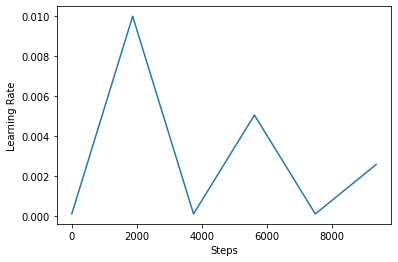

In [10]:
step = np.arange(0, EPOCHS * steps_per_epoch)
lr = clr(step)
plt.plot(step, lr)
plt.xlabel("Steps")
plt.ylabel("Learning Rate")
plt.show()

In order to better visualize the effect of CLR, you can plot the schedule with an increased number of steps. 

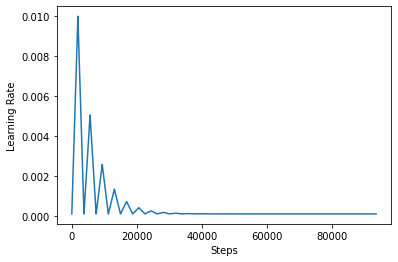

In [11]:
step = np.arange(0, 100 * steps_per_epoch)
lr = clr(step)
plt.plot(step, lr)
plt.xlabel("Steps")
plt.ylabel("Learning Rate")
plt.show()

The function you are using in this tutorial is referred to as the `triangular2` method in the CLR paper. There are other two functions there were explored namely `triangular` and `exp` (short for exponential). 

## Train a model with CLR

In [12]:
clr_model = tf.keras.models.load_model("initial_model")
clr_history = train_model(clr_model, optimizer=optimizer)

Epoch 1/10


  1/938 [..............................] - ETA: 6:15 - loss: 2.3044 - accuracy: 0.0938

 19/938 [..............................] - ETA: 2s - loss: 2.3093 - accuracy: 0.0781  

 37/938 [>.............................] - ETA: 2s - loss: 2.3089 - accuracy: 0.0845

 55/938 [>.............................] - ETA: 2s - loss: 2.3094 - accuracy: 0.0832

 72/938 [=>............................] - ETA: 2s - loss: 2.3089 - accuracy: 0.0853

 89/938 [=>............................] - ETA: 2s - loss: 2.3082 - accuracy: 0.0883

106/938 [==>...........................] - ETA: 2s - loss: 2.3080 - accuracy: 0.0879

124/938 [==>...........................] - ETA: 2s - loss: 2.3082 - accuracy: 0.0876

142/938 [===>..........................] - ETA: 2s - loss: 2.3081 - accuracy: 0.0882

160/938 [====>.........................] - ETA: 2s - loss: 2.3079 - accuracy: 0.0901

178/938 [====>.........................] - ETA: 2s - loss: 2.3079 - accuracy: 0.0897

196/938 [=====>........................] - ETA: 2s - loss: 2.3076 - accuracy: 0.0896

215/938 [=====>........................] - ETA: 2s - loss: 2.3077 - accuracy: 0.0898

233/938 [======>.......................] - ETA: 2s - loss: 2.3076 - accuracy: 0.0907

251/938 [=======>......................] - ETA: 1s - loss: 2.3073 - accuracy: 0.0919

269/938 [=======>......................] - ETA: 1s - loss: 2.3072 - accuracy: 0.0929

287/938 [========>.....................] - ETA: 1s - loss: 2.3069 - accuracy: 0.0946

305/938 [========>.....................] - ETA: 1s - loss: 2.3069 - accuracy: 0.0955

324/938 [=========>....................] - ETA: 1s - loss: 2.3067 - accuracy: 0.0960

343/938 [=========>....................] - ETA: 1s - loss: 2.3066 - accuracy: 0.0964

361/938 [==========>...................] - ETA: 1s - loss: 2.3064 - accuracy: 0.0968

379/938 [===========>..................] - ETA: 1s - loss: 2.3063 - accuracy: 0.0973

398/938 [===========>..................] - ETA: 1s - loss: 2.3061 - accuracy: 0.0977

417/938 [============>.................] - ETA: 1s - loss: 2.3060 - accuracy: 0.0976

435/938 [============>.................] - ETA: 1s - loss: 2.3059 - accuracy: 0.0978

454/938 [=============>................] - ETA: 1s - loss: 2.3057 - accuracy: 0.0983

473/938 [==============>...............] - ETA: 1s - loss: 2.3056 - accuracy: 0.0988

492/938 [==============>...............] - ETA: 1s - loss: 2.3053 - accuracy: 0.0996

511/938 [===============>..............] - ETA: 1s - loss: 2.3051 - accuracy: 0.0995

530/938 [===============>..............] - ETA: 1s - loss: 2.3050 - accuracy: 0.0999

548/938 [================>.............] - ETA: 1s - loss: 2.3049 - accuracy: 0.1003

567/938 [=================>............] - ETA: 1s - loss: 2.3046 - accuracy: 0.1014

586/938 [=================>............] - ETA: 0s - loss: 2.3044 - accuracy: 0.1015

605/938 [==================>...........] - ETA: 0s - loss: 2.3043 - accuracy: 0.1018

624/938 [==================>...........] - ETA: 0s - loss: 2.3041 - accuracy: 0.1028

642/938 [===================>..........] - ETA: 0s - loss: 2.3039 - accuracy: 0.1029

660/938 [====================>.........] - ETA: 0s - loss: 2.3037 - accuracy: 0.1036

678/938 [====================>.........] - ETA: 0s - loss: 2.3035 - accuracy: 0.1045

696/938 [=====================>........] - ETA: 0s - loss: 2.3033 - accuracy: 0.1051

714/938 [=====================>........] - ETA: 0s - loss: 2.3031 - accuracy: 0.1054

733/938 [======================>.......] - ETA: 0s - loss: 2.3029 - accuracy: 0.1064

752/938 [=======================>......] - ETA: 0s - loss: 2.3027 - accuracy: 0.1069

770/938 [=======================>......] - ETA: 0s - loss: 2.3025 - accuracy: 0.1075

788/938 [========================>.....] - ETA: 0s - loss: 2.3023 - accuracy: 0.1080

806/938 [========================>.....] - ETA: 0s - loss: 2.3021 - accuracy: 0.1092

824/938 [=========================>....] - ETA: 0s - loss: 2.3019 - accuracy: 0.1101

843/938 [=========================>....] - ETA: 0s - loss: 2.3016 - accuracy: 0.1116

861/938 [==========================>...] - ETA: 0s - loss: 2.3014 - accuracy: 0.1124

880/938 [===========================>..] - ETA: 0s - loss: 2.3012 - accuracy: 0.1136

899/938 [===========================>..] - ETA: 0s - loss: 2.3010 - accuracy: 0.1144

918/938 [============================>.] - ETA: 0s - loss: 2.3007 - accuracy: 0.1154

936/938 [============================>.] - ETA: 0s - loss: 2.3005 - accuracy: 0.1165

938/938 [==============================] - 3s 3ms/step - loss: 2.3005 - accuracy: 0.1165 - val_loss: 2.2852 - val_accuracy: 0.2375


Epoch 2/10


  1/938 [..............................] - ETA: 3s - loss: 2.2740 - accuracy: 0.2344

 19/938 [..............................] - ETA: 2s - loss: 2.2866 - accuracy: 0.1752

 37/938 [>.............................] - ETA: 2s - loss: 2.2867 - accuracy: 0.1655

 56/938 [>.............................] - ETA: 2s - loss: 2.2871 - accuracy: 0.1610

 74/938 [=>............................] - ETA: 2s - loss: 2.2870 - accuracy: 0.1622

 92/938 [=>............................] - ETA: 2s - loss: 2.2864 - accuracy: 0.1659

110/938 [==>...........................] - ETA: 2s - loss: 2.2860 - accuracy: 0.1702

128/938 [===>..........................] - ETA: 2s - loss: 2.2858 - accuracy: 0.1685

147/938 [===>..........................] - ETA: 2s - loss: 2.2853 - accuracy: 0.1714

166/938 [====>.........................] - ETA: 2s - loss: 2.2846 - accuracy: 0.1742

184/938 [====>.........................] - ETA: 2s - loss: 2.2840 - accuracy: 0.1758

202/938 [=====>........................] - ETA: 2s - loss: 2.2835 - accuracy: 0.1778

220/938 [======>.......................] - ETA: 2s - loss: 2.2829 - accuracy: 0.1803

239/938 [======>.......................] - ETA: 1s - loss: 2.2818 - accuracy: 0.1838

258/938 [=======>......................] - ETA: 1s - loss: 2.2813 - accuracy: 0.1842

277/938 [=======>......................] - ETA: 1s - loss: 2.2809 - accuracy: 0.1843

295/938 [========>.....................] - ETA: 1s - loss: 2.2802 - accuracy: 0.1856

313/938 [=========>....................] - ETA: 1s - loss: 2.2797 - accuracy: 0.1869

331/938 [=========>....................] - ETA: 1s - loss: 2.2790 - accuracy: 0.1876

349/938 [==========>...................] - ETA: 1s - loss: 2.2784 - accuracy: 0.1884

367/938 [==========>...................] - ETA: 1s - loss: 2.2777 - accuracy: 0.1894

385/938 [===========>..................] - ETA: 1s - loss: 2.2770 - accuracy: 0.1906

402/938 [===========>..................] - ETA: 1s - loss: 2.2761 - accuracy: 0.1924

419/938 [============>.................] - ETA: 1s - loss: 2.2753 - accuracy: 0.1931

438/938 [=============>................] - ETA: 1s - loss: 2.2745 - accuracy: 0.1942

456/938 [=============>................] - ETA: 1s - loss: 2.2732 - accuracy: 0.1959

475/938 [==============>...............] - ETA: 1s - loss: 2.2721 - accuracy: 0.1973

494/938 [==============>...............] - ETA: 1s - loss: 2.2707 - accuracy: 0.1993

513/938 [===============>..............] - ETA: 1s - loss: 2.2693 - accuracy: 0.2012

532/938 [================>.............] - ETA: 1s - loss: 2.2680 - accuracy: 0.2027

551/938 [================>.............] - ETA: 1s - loss: 2.2666 - accuracy: 0.2045

570/938 [=================>............] - ETA: 1s - loss: 2.2651 - accuracy: 0.2049

589/938 [=================>............] - ETA: 0s - loss: 2.2636 - accuracy: 0.2063

608/938 [==================>...........] - ETA: 0s - loss: 2.2619 - accuracy: 0.2073

627/938 [===================>..........] - ETA: 0s - loss: 2.2602 - accuracy: 0.2085

646/938 [===================>..........] - ETA: 0s - loss: 2.2580 - accuracy: 0.2108

665/938 [====================>.........] - ETA: 0s - loss: 2.2559 - accuracy: 0.2120

684/938 [====================>.........] - ETA: 0s - loss: 2.2534 - accuracy: 0.2137

703/938 [=====================>........] - ETA: 0s - loss: 2.2510 - accuracy: 0.2147

722/938 [======================>.......] - ETA: 0s - loss: 2.2484 - accuracy: 0.2157

741/938 [======================>.......] - ETA: 0s - loss: 2.2455 - accuracy: 0.2177

760/938 [=======================>......] - ETA: 0s - loss: 2.2420 - accuracy: 0.2200

779/938 [=======================>......] - ETA: 0s - loss: 2.2387 - accuracy: 0.2219

798/938 [========================>.....] - ETA: 0s - loss: 2.2349 - accuracy: 0.2238

817/938 [=========================>....] - ETA: 0s - loss: 2.2306 - accuracy: 0.2263

836/938 [=========================>....] - ETA: 0s - loss: 2.2257 - accuracy: 0.2284

855/938 [==========================>...] - ETA: 0s - loss: 2.2206 - accuracy: 0.2301

874/938 [==========================>...] - ETA: 0s - loss: 2.2151 - accuracy: 0.2321

893/938 [===========================>..] - ETA: 0s - loss: 2.2091 - accuracy: 0.2345

912/938 [============================>.] - ETA: 0s - loss: 2.2028 - accuracy: 0.2367

931/938 [============================>.] - ETA: 0s - loss: 2.1958 - accuracy: 0.2389

938/938 [==============================] - 3s 3ms/step - loss: 2.1930 - accuracy: 0.2397 - val_loss: 1.7384 - val_accuracy: 0.4520


Epoch 3/10


  1/938 [..............................] - ETA: 3s - loss: 1.7795 - accuracy: 0.4375

 19/938 [..............................] - ETA: 2s - loss: 1.7864 - accuracy: 0.3717

 38/938 [>.............................] - ETA: 2s - loss: 1.7624 - accuracy: 0.3799

 57/938 [>.............................] - ETA: 2s - loss: 1.7465 - accuracy: 0.3808

 76/938 [=>............................] - ETA: 2s - loss: 1.7230 - accuracy: 0.3898

 95/938 [==>...........................] - ETA: 2s - loss: 1.6998 - accuracy: 0.3914

114/938 [==>...........................] - ETA: 2s - loss: 1.6844 - accuracy: 0.3942

133/938 [===>..........................] - ETA: 2s - loss: 1.6672 - accuracy: 0.3979

152/938 [===>..........................] - ETA: 2s - loss: 1.6499 - accuracy: 0.4025

171/938 [====>.........................] - ETA: 2s - loss: 1.6311 - accuracy: 0.4067

190/938 [=====>........................] - ETA: 2s - loss: 1.6172 - accuracy: 0.4096

209/938 [=====>........................] - ETA: 1s - loss: 1.6014 - accuracy: 0.4147

228/938 [======>.......................] - ETA: 1s - loss: 1.5886 - accuracy: 0.4164

247/938 [======>.......................] - ETA: 1s - loss: 1.5759 - accuracy: 0.4193

266/938 [=======>......................] - ETA: 1s - loss: 1.5625 - accuracy: 0.4230

285/938 [========>.....................] - ETA: 1s - loss: 1.5491 - accuracy: 0.4276

304/938 [========>.....................] - ETA: 1s - loss: 1.5377 - accuracy: 0.4321

323/938 [=========>....................] - ETA: 1s - loss: 1.5249 - accuracy: 0.4357

342/938 [=========>....................] - ETA: 1s - loss: 1.5138 - accuracy: 0.4392

361/938 [==========>...................] - ETA: 1s - loss: 1.5044 - accuracy: 0.4421

381/938 [===========>..................] - ETA: 1s - loss: 1.4928 - accuracy: 0.4458

401/938 [===========>..................] - ETA: 1s - loss: 1.4845 - accuracy: 0.4483

420/938 [============>.................] - ETA: 1s - loss: 1.4759 - accuracy: 0.4510

439/938 [=============>................] - ETA: 1s - loss: 1.4677 - accuracy: 0.4536

458/938 [=============>................] - ETA: 1s - loss: 1.4595 - accuracy: 0.4558

477/938 [==============>...............] - ETA: 1s - loss: 1.4510 - accuracy: 0.4580

496/938 [==============>...............] - ETA: 1s - loss: 1.4423 - accuracy: 0.4606

515/938 [===============>..............] - ETA: 1s - loss: 1.4345 - accuracy: 0.4627

534/938 [================>.............] - ETA: 1s - loss: 1.4274 - accuracy: 0.4649

554/938 [================>.............] - ETA: 1s - loss: 1.4197 - accuracy: 0.4666

573/938 [=================>............] - ETA: 0s - loss: 1.4127 - accuracy: 0.4689

592/938 [=================>............] - ETA: 0s - loss: 1.4060 - accuracy: 0.4710

611/938 [==================>...........] - ETA: 0s - loss: 1.4006 - accuracy: 0.4728

630/938 [===================>..........] - ETA: 0s - loss: 1.3941 - accuracy: 0.4754

648/938 [===================>..........] - ETA: 0s - loss: 1.3882 - accuracy: 0.4776

667/938 [====================>.........] - ETA: 0s - loss: 1.3823 - accuracy: 0.4797

686/938 [====================>.........] - ETA: 0s - loss: 1.3767 - accuracy: 0.4817

705/938 [=====================>........] - ETA: 0s - loss: 1.3712 - accuracy: 0.4838

723/938 [======================>.......] - ETA: 0s - loss: 1.3669 - accuracy: 0.4853

742/938 [======================>.......] - ETA: 0s - loss: 1.3607 - accuracy: 0.4877

761/938 [=======================>......] - ETA: 0s - loss: 1.3558 - accuracy: 0.4893

780/938 [=======================>......] - ETA: 0s - loss: 1.3505 - accuracy: 0.4914

799/938 [========================>.....] - ETA: 0s - loss: 1.3463 - accuracy: 0.4927

818/938 [=========================>....] - ETA: 0s - loss: 1.3406 - accuracy: 0.4945

837/938 [=========================>....] - ETA: 0s - loss: 1.3364 - accuracy: 0.4959

856/938 [==========================>...] - ETA: 0s - loss: 1.3317 - accuracy: 0.4978

875/938 [==========================>...] - ETA: 0s - loss: 1.3267 - accuracy: 0.4996

894/938 [===========================>..] - ETA: 0s - loss: 1.3226 - accuracy: 0.5015

914/938 [============================>.] - ETA: 0s - loss: 1.3179 - accuracy: 0.5034

933/938 [============================>.] - ETA: 0s - loss: 1.3142 - accuracy: 0.5051

938/938 [==============================] - 3s 3ms/step - loss: 1.3132 - accuracy: 0.5055 - val_loss: 1.0109 - val_accuracy: 0.6493


Epoch 4/10


  1/938 [..............................] - ETA: 3s - loss: 1.0845 - accuracy: 0.5469

 19/938 [..............................] - ETA: 2s - loss: 1.1125 - accuracy: 0.5781

 37/938 [>.............................] - ETA: 2s - loss: 1.1165 - accuracy: 0.5739

 55/938 [>.............................] - ETA: 2s - loss: 1.1166 - accuracy: 0.5759

 73/938 [=>............................] - ETA: 2s - loss: 1.1108 - accuracy: 0.5788

 91/938 [=>............................] - ETA: 2s - loss: 1.1196 - accuracy: 0.5730

109/938 [==>...........................] - ETA: 2s - loss: 1.1235 - accuracy: 0.5669

128/938 [===>..........................] - ETA: 2s - loss: 1.1181 - accuracy: 0.5708

146/938 [===>..........................] - ETA: 2s - loss: 1.1172 - accuracy: 0.5728

164/938 [====>.........................] - ETA: 2s - loss: 1.1152 - accuracy: 0.5728

182/938 [====>.........................] - ETA: 2s - loss: 1.1162 - accuracy: 0.5727

200/938 [=====>........................] - ETA: 2s - loss: 1.1112 - accuracy: 0.5741

218/938 [=====>........................] - ETA: 2s - loss: 1.1079 - accuracy: 0.5750

236/938 [======>.......................] - ETA: 1s - loss: 1.1073 - accuracy: 0.5761

254/938 [=======>......................] - ETA: 1s - loss: 1.1044 - accuracy: 0.5776

272/938 [=======>......................] - ETA: 1s - loss: 1.1045 - accuracy: 0.5780

291/938 [========>.....................] - ETA: 1s - loss: 1.1045 - accuracy: 0.5784

310/938 [========>.....................] - ETA: 1s - loss: 1.1030 - accuracy: 0.5797

329/938 [=========>....................] - ETA: 1s - loss: 1.1006 - accuracy: 0.5808

347/938 [==========>...................] - ETA: 1s - loss: 1.1029 - accuracy: 0.5803

365/938 [==========>...................] - ETA: 1s - loss: 1.1023 - accuracy: 0.5811

384/938 [===========>..................] - ETA: 1s - loss: 1.1001 - accuracy: 0.5822

402/938 [===========>..................] - ETA: 1s - loss: 1.0975 - accuracy: 0.5830

420/938 [============>.................] - ETA: 1s - loss: 1.0965 - accuracy: 0.5834

438/938 [=============>................] - ETA: 1s - loss: 1.0950 - accuracy: 0.5839

456/938 [=============>................] - ETA: 1s - loss: 1.0939 - accuracy: 0.5840

475/938 [==============>...............] - ETA: 1s - loss: 1.0946 - accuracy: 0.5833

494/938 [==============>...............] - ETA: 1s - loss: 1.0959 - accuracy: 0.5829

513/938 [===============>..............] - ETA: 1s - loss: 1.0941 - accuracy: 0.5838

532/938 [================>.............] - ETA: 1s - loss: 1.0924 - accuracy: 0.5844

551/938 [================>.............] - ETA: 1s - loss: 1.0893 - accuracy: 0.5861

569/938 [=================>............] - ETA: 1s - loss: 1.0887 - accuracy: 0.5864

587/938 [=================>............] - ETA: 0s - loss: 1.0889 - accuracy: 0.5862

605/938 [==================>...........] - ETA: 0s - loss: 1.0894 - accuracy: 0.5862

623/938 [==================>...........] - ETA: 0s - loss: 1.0887 - accuracy: 0.5865

641/938 [===================>..........] - ETA: 0s - loss: 1.0870 - accuracy: 0.5872

660/938 [====================>.........] - ETA: 0s - loss: 1.0848 - accuracy: 0.5882

679/938 [====================>.........] - ETA: 0s - loss: 1.0845 - accuracy: 0.5882

698/938 [=====================>........] - ETA: 0s - loss: 1.0827 - accuracy: 0.5888

717/938 [=====================>........] - ETA: 0s - loss: 1.0820 - accuracy: 0.5887

736/938 [======================>.......] - ETA: 0s - loss: 1.0806 - accuracy: 0.5897

755/938 [=======================>......] - ETA: 0s - loss: 1.0800 - accuracy: 0.5896

774/938 [=======================>......] - ETA: 0s - loss: 1.0794 - accuracy: 0.5900

793/938 [========================>.....] - ETA: 0s - loss: 1.0794 - accuracy: 0.5898

812/938 [========================>.....] - ETA: 0s - loss: 1.0787 - accuracy: 0.5900

831/938 [=========================>....] - ETA: 0s - loss: 1.0781 - accuracy: 0.5905

849/938 [==========================>...] - ETA: 0s - loss: 1.0777 - accuracy: 0.5916

868/938 [==========================>...] - ETA: 0s - loss: 1.0776 - accuracy: 0.5919

886/938 [===========================>..] - ETA: 0s - loss: 1.0778 - accuracy: 0.5919

905/938 [===========================>..] - ETA: 0s - loss: 1.0769 - accuracy: 0.5925

923/938 [============================>.] - ETA: 0s - loss: 1.0762 - accuracy: 0.5926

938/938 [==============================] - 3s 3ms/step - loss: 1.0748 - accuracy: 0.5930 - val_loss: 0.9493 - val_accuracy: 0.6625


Epoch 5/10


  1/938 [..............................] - ETA: 3s - loss: 0.9051 - accuracy: 0.6875

 20/938 [..............................] - ETA: 2s - loss: 1.0302 - accuracy: 0.6070

 39/938 [>.............................] - ETA: 2s - loss: 1.0650 - accuracy: 0.5909

 57/938 [>.............................] - ETA: 2s - loss: 1.0553 - accuracy: 0.6003

 76/938 [=>............................] - ETA: 2s - loss: 1.0566 - accuracy: 0.6001

 95/938 [==>...........................] - ETA: 2s - loss: 1.0645 - accuracy: 0.5993

113/938 [==>...........................] - ETA: 2s - loss: 1.0600 - accuracy: 0.6008

132/938 [===>..........................] - ETA: 2s - loss: 1.0577 - accuracy: 0.6026

151/938 [===>..........................] - ETA: 2s - loss: 1.0605 - accuracy: 0.6017

170/938 [====>.........................] - ETA: 2s - loss: 1.0623 - accuracy: 0.5985

189/938 [=====>........................] - ETA: 2s - loss: 1.0598 - accuracy: 0.6000

208/938 [=====>........................] - ETA: 1s - loss: 1.0585 - accuracy: 0.6000

227/938 [======>.......................] - ETA: 1s - loss: 1.0590 - accuracy: 0.6011

245/938 [======>.......................] - ETA: 1s - loss: 1.0573 - accuracy: 0.6020

263/938 [=======>......................] - ETA: 1s - loss: 1.0565 - accuracy: 0.6028

280/938 [=======>......................] - ETA: 1s - loss: 1.0564 - accuracy: 0.6024

299/938 [========>.....................] - ETA: 1s - loss: 1.0571 - accuracy: 0.6017

318/938 [=========>....................] - ETA: 1s - loss: 1.0592 - accuracy: 0.6013

337/938 [=========>....................] - ETA: 1s - loss: 1.0603 - accuracy: 0.6016

355/938 [==========>...................] - ETA: 1s - loss: 1.0596 - accuracy: 0.6014

373/938 [==========>...................] - ETA: 1s - loss: 1.0578 - accuracy: 0.6021

392/938 [===========>..................] - ETA: 1s - loss: 1.0570 - accuracy: 0.6017

410/938 [============>.................] - ETA: 1s - loss: 1.0575 - accuracy: 0.6012

428/938 [============>.................] - ETA: 1s - loss: 1.0580 - accuracy: 0.6015

446/938 [=============>................] - ETA: 1s - loss: 1.0574 - accuracy: 0.6020

464/938 [=============>................] - ETA: 1s - loss: 1.0556 - accuracy: 0.6032

482/938 [==============>...............] - ETA: 1s - loss: 1.0550 - accuracy: 0.6034

501/938 [===============>..............] - ETA: 1s - loss: 1.0543 - accuracy: 0.6038

520/938 [===============>..............] - ETA: 1s - loss: 1.0541 - accuracy: 0.6038

539/938 [================>.............] - ETA: 1s - loss: 1.0542 - accuracy: 0.6042

558/938 [================>.............] - ETA: 1s - loss: 1.0569 - accuracy: 0.6030

577/938 [=================>............] - ETA: 0s - loss: 1.0575 - accuracy: 0.6028

596/938 [==================>...........] - ETA: 0s - loss: 1.0591 - accuracy: 0.6022

615/938 [==================>...........] - ETA: 0s - loss: 1.0581 - accuracy: 0.6022

634/938 [===================>..........] - ETA: 0s - loss: 1.0570 - accuracy: 0.6028

652/938 [===================>..........] - ETA: 0s - loss: 1.0574 - accuracy: 0.6024

671/938 [====================>.........] - ETA: 0s - loss: 1.0565 - accuracy: 0.6025

690/938 [=====================>........] - ETA: 0s - loss: 1.0564 - accuracy: 0.6020

709/938 [=====================>........] - ETA: 0s - loss: 1.0562 - accuracy: 0.6018

728/938 [======================>.......] - ETA: 0s - loss: 1.0562 - accuracy: 0.6023

747/938 [======================>.......] - ETA: 0s - loss: 1.0568 - accuracy: 0.6021

767/938 [=======================>......] - ETA: 0s - loss: 1.0561 - accuracy: 0.6029

786/938 [========================>.....] - ETA: 0s - loss: 1.0564 - accuracy: 0.6026

805/938 [========================>.....] - ETA: 0s - loss: 1.0554 - accuracy: 0.6030

824/938 [=========================>....] - ETA: 0s - loss: 1.0553 - accuracy: 0.6033

843/938 [=========================>....] - ETA: 0s - loss: 1.0542 - accuracy: 0.6034

862/938 [==========================>...] - ETA: 0s - loss: 1.0532 - accuracy: 0.6029

881/938 [===========================>..] - ETA: 0s - loss: 1.0531 - accuracy: 0.6028

900/938 [===========================>..] - ETA: 0s - loss: 1.0527 - accuracy: 0.6027

919/938 [============================>.] - ETA: 0s - loss: 1.0536 - accuracy: 0.6025

938/938 [==============================] - ETA: 0s - loss: 1.0530 - accuracy: 0.6028

938/938 [==============================] - 3s 3ms/step - loss: 1.0530 - accuracy: 0.6028 - val_loss: 0.9441 - val_accuracy: 0.6523


Epoch 6/10


  1/938 [..............................] - ETA: 3s - loss: 1.1597 - accuracy: 0.5938

 19/938 [..............................] - ETA: 2s - loss: 1.0621 - accuracy: 0.6053

 37/938 [>.............................] - ETA: 2s - loss: 1.0504 - accuracy: 0.6047

 55/938 [>.............................] - ETA: 2s - loss: 1.0359 - accuracy: 0.6145

 74/938 [=>............................] - ETA: 2s - loss: 1.0390 - accuracy: 0.6153

 93/938 [=>............................] - ETA: 2s - loss: 1.0377 - accuracy: 0.6112

112/938 [==>...........................] - ETA: 2s - loss: 1.0395 - accuracy: 0.6115

131/938 [===>..........................] - ETA: 2s - loss: 1.0425 - accuracy: 0.6131

149/938 [===>..........................] - ETA: 2s - loss: 1.0451 - accuracy: 0.6090

168/938 [====>.........................] - ETA: 2s - loss: 1.0439 - accuracy: 0.6091

187/938 [====>.........................] - ETA: 2s - loss: 1.0426 - accuracy: 0.6083

206/938 [=====>........................] - ETA: 2s - loss: 1.0405 - accuracy: 0.6101

225/938 [======>.......................] - ETA: 1s - loss: 1.0395 - accuracy: 0.6117

244/938 [======>.......................] - ETA: 1s - loss: 1.0351 - accuracy: 0.6126

263/938 [=======>......................] - ETA: 1s - loss: 1.0324 - accuracy: 0.6129

282/938 [========>.....................] - ETA: 1s - loss: 1.0332 - accuracy: 0.6124

301/938 [========>.....................] - ETA: 1s - loss: 1.0331 - accuracy: 0.6120

319/938 [=========>....................] - ETA: 1s - loss: 1.0309 - accuracy: 0.6123

338/938 [=========>....................] - ETA: 1s - loss: 1.0309 - accuracy: 0.6123

356/938 [==========>...................] - ETA: 1s - loss: 1.0299 - accuracy: 0.6129

375/938 [==========>...................] - ETA: 1s - loss: 1.0290 - accuracy: 0.6132

394/938 [===========>..................] - ETA: 1s - loss: 1.0285 - accuracy: 0.6134

413/938 [============>.................] - ETA: 1s - loss: 1.0293 - accuracy: 0.6130

432/938 [============>.................] - ETA: 1s - loss: 1.0283 - accuracy: 0.6140

451/938 [=============>................] - ETA: 1s - loss: 1.0302 - accuracy: 0.6131

469/938 [==============>...............] - ETA: 1s - loss: 1.0314 - accuracy: 0.6123

488/938 [==============>...............] - ETA: 1s - loss: 1.0317 - accuracy: 0.6128

506/938 [===============>..............] - ETA: 1s - loss: 1.0303 - accuracy: 0.6132

525/938 [===============>..............] - ETA: 1s - loss: 1.0303 - accuracy: 0.6132

543/938 [================>.............] - ETA: 1s - loss: 1.0295 - accuracy: 0.6136

562/938 [================>.............] - ETA: 1s - loss: 1.0279 - accuracy: 0.6145

581/938 [=================>............] - ETA: 0s - loss: 1.0278 - accuracy: 0.6143

600/938 [==================>...........] - ETA: 0s - loss: 1.0275 - accuracy: 0.6148

619/938 [==================>...........] - ETA: 0s - loss: 1.0283 - accuracy: 0.6145

637/938 [===================>..........] - ETA: 0s - loss: 1.0280 - accuracy: 0.6146

656/938 [===================>..........] - ETA: 0s - loss: 1.0281 - accuracy: 0.6149

674/938 [====================>.........] - ETA: 0s - loss: 1.0276 - accuracy: 0.6148

693/938 [=====================>........] - ETA: 0s - loss: 1.0271 - accuracy: 0.6150

711/938 [=====================>........] - ETA: 0s - loss: 1.0259 - accuracy: 0.6154

729/938 [======================>.......] - ETA: 0s - loss: 1.0255 - accuracy: 0.6152

747/938 [======================>.......] - ETA: 0s - loss: 1.0246 - accuracy: 0.6159

766/938 [=======================>......] - ETA: 0s - loss: 1.0236 - accuracy: 0.6163

785/938 [========================>.....] - ETA: 0s - loss: 1.0232 - accuracy: 0.6168

803/938 [========================>.....] - ETA: 0s - loss: 1.0227 - accuracy: 0.6167

821/938 [=========================>....] - ETA: 0s - loss: 1.0225 - accuracy: 0.6164

839/938 [=========================>....] - ETA: 0s - loss: 1.0220 - accuracy: 0.6164

858/938 [==========================>...] - ETA: 0s - loss: 1.0213 - accuracy: 0.6168

877/938 [===========================>..] - ETA: 0s - loss: 1.0209 - accuracy: 0.6168

895/938 [===========================>..] - ETA: 0s - loss: 1.0202 - accuracy: 0.6170

914/938 [============================>.] - ETA: 0s - loss: 1.0201 - accuracy: 0.6168

933/938 [============================>.] - ETA: 0s - loss: 1.0199 - accuracy: 0.6170

938/938 [==============================] - 3s 3ms/step - loss: 1.0199 - accuracy: 0.6172 - val_loss: 0.9101 - val_accuracy: 0.6617


Epoch 7/10


  1/938 [..............................] - ETA: 3s - loss: 1.0678 - accuracy: 0.6094

 20/938 [..............................] - ETA: 2s - loss: 0.9887 - accuracy: 0.6289

 39/938 [>.............................] - ETA: 2s - loss: 0.9810 - accuracy: 0.6318

 58/938 [>.............................] - ETA: 2s - loss: 0.9912 - accuracy: 0.6245

 77/938 [=>............................] - ETA: 2s - loss: 0.9888 - accuracy: 0.6313

 96/938 [==>...........................] - ETA: 2s - loss: 0.9829 - accuracy: 0.6335

114/938 [==>...........................] - ETA: 2s - loss: 0.9851 - accuracy: 0.6279

133/938 [===>..........................] - ETA: 2s - loss: 0.9804 - accuracy: 0.6310

152/938 [===>..........................] - ETA: 2s - loss: 0.9781 - accuracy: 0.6314

171/938 [====>.........................] - ETA: 2s - loss: 0.9857 - accuracy: 0.6285

190/938 [=====>........................] - ETA: 2s - loss: 0.9819 - accuracy: 0.6276

209/938 [=====>........................] - ETA: 1s - loss: 0.9846 - accuracy: 0.6268

227/938 [======>.......................] - ETA: 1s - loss: 0.9848 - accuracy: 0.6277

246/938 [======>.......................] - ETA: 1s - loss: 0.9852 - accuracy: 0.6300

264/938 [=======>......................] - ETA: 1s - loss: 0.9878 - accuracy: 0.6297

282/938 [========>.....................] - ETA: 1s - loss: 0.9837 - accuracy: 0.6307

301/938 [========>.....................] - ETA: 1s - loss: 0.9817 - accuracy: 0.6311

320/938 [=========>....................] - ETA: 1s - loss: 0.9819 - accuracy: 0.6307

339/938 [=========>....................] - ETA: 1s - loss: 0.9803 - accuracy: 0.6319

358/938 [==========>...................] - ETA: 1s - loss: 0.9829 - accuracy: 0.6316

377/938 [===========>..................] - ETA: 1s - loss: 0.9838 - accuracy: 0.6320

396/938 [===========>..................] - ETA: 1s - loss: 0.9829 - accuracy: 0.6326

414/938 [============>.................] - ETA: 1s - loss: 0.9831 - accuracy: 0.6333

433/938 [============>.................] - ETA: 1s - loss: 0.9828 - accuracy: 0.6332

451/938 [=============>................] - ETA: 1s - loss: 0.9821 - accuracy: 0.6326

470/938 [==============>...............] - ETA: 1s - loss: 0.9820 - accuracy: 0.6328

489/938 [==============>...............] - ETA: 1s - loss: 0.9812 - accuracy: 0.6332

508/938 [===============>..............] - ETA: 1s - loss: 0.9806 - accuracy: 0.6333

527/938 [===============>..............] - ETA: 1s - loss: 0.9808 - accuracy: 0.6335

546/938 [================>.............] - ETA: 1s - loss: 0.9802 - accuracy: 0.6332

565/938 [=================>............] - ETA: 1s - loss: 0.9798 - accuracy: 0.6338

583/938 [=================>............] - ETA: 0s - loss: 0.9799 - accuracy: 0.6335

601/938 [==================>...........] - ETA: 0s - loss: 0.9803 - accuracy: 0.6329

619/938 [==================>...........] - ETA: 0s - loss: 0.9812 - accuracy: 0.6327

638/938 [===================>..........] - ETA: 0s - loss: 0.9800 - accuracy: 0.6327

656/938 [===================>..........] - ETA: 0s - loss: 0.9794 - accuracy: 0.6331

675/938 [====================>.........] - ETA: 0s - loss: 0.9788 - accuracy: 0.6336

694/938 [=====================>........] - ETA: 0s - loss: 0.9795 - accuracy: 0.6334

713/938 [=====================>........] - ETA: 0s - loss: 0.9794 - accuracy: 0.6336

731/938 [======================>.......] - ETA: 0s - loss: 0.9789 - accuracy: 0.6337

750/938 [======================>.......] - ETA: 0s - loss: 0.9785 - accuracy: 0.6340

768/938 [=======================>......] - ETA: 0s - loss: 0.9792 - accuracy: 0.6333

786/938 [========================>.....] - ETA: 0s - loss: 0.9799 - accuracy: 0.6327

805/938 [========================>.....] - ETA: 0s - loss: 0.9800 - accuracy: 0.6331

824/938 [=========================>....] - ETA: 0s - loss: 0.9788 - accuracy: 0.6337

843/938 [=========================>....] - ETA: 0s - loss: 0.9796 - accuracy: 0.6335

862/938 [==========================>...] - ETA: 0s - loss: 0.9796 - accuracy: 0.6338

881/938 [===========================>..] - ETA: 0s - loss: 0.9792 - accuracy: 0.6340

900/938 [===========================>..] - ETA: 0s - loss: 0.9791 - accuracy: 0.6340

919/938 [============================>.] - ETA: 0s - loss: 0.9786 - accuracy: 0.6344

938/938 [==============================] - ETA: 0s - loss: 0.9780 - accuracy: 0.6345

938/938 [==============================] - 3s 3ms/step - loss: 0.9780 - accuracy: 0.6345 - val_loss: 0.8785 - val_accuracy: 0.6755


Epoch 8/10


  1/938 [..............................] - ETA: 3s - loss: 1.1313 - accuracy: 0.6562

 20/938 [..............................] - ETA: 2s - loss: 0.9448 - accuracy: 0.6547

 39/938 [>.............................] - ETA: 2s - loss: 0.9356 - accuracy: 0.6526

 57/938 [>.............................] - ETA: 2s - loss: 0.9427 - accuracy: 0.6519

 76/938 [=>............................] - ETA: 2s - loss: 0.9527 - accuracy: 0.6546

 95/938 [==>...........................] - ETA: 2s - loss: 0.9464 - accuracy: 0.6566

113/938 [==>...........................] - ETA: 2s - loss: 0.9463 - accuracy: 0.6561

132/938 [===>..........................] - ETA: 2s - loss: 0.9452 - accuracy: 0.6573

151/938 [===>..........................] - ETA: 2s - loss: 0.9484 - accuracy: 0.6545

170/938 [====>.........................] - ETA: 2s - loss: 0.9519 - accuracy: 0.6515

189/938 [=====>........................] - ETA: 2s - loss: 0.9535 - accuracy: 0.6509

208/938 [=====>........................] - ETA: 1s - loss: 0.9529 - accuracy: 0.6503

227/938 [======>.......................] - ETA: 1s - loss: 0.9562 - accuracy: 0.6486

246/938 [======>.......................] - ETA: 1s - loss: 0.9582 - accuracy: 0.6481

265/938 [=======>......................] - ETA: 1s - loss: 0.9578 - accuracy: 0.6482

283/938 [========>.....................] - ETA: 1s - loss: 0.9535 - accuracy: 0.6497

302/938 [========>.....................] - ETA: 1s - loss: 0.9511 - accuracy: 0.6495

320/938 [=========>....................] - ETA: 1s - loss: 0.9506 - accuracy: 0.6506

339/938 [=========>....................] - ETA: 1s - loss: 0.9541 - accuracy: 0.6504

358/938 [==========>...................] - ETA: 1s - loss: 0.9560 - accuracy: 0.6497

377/938 [===========>..................] - ETA: 1s - loss: 0.9571 - accuracy: 0.6493

396/938 [===========>..................] - ETA: 1s - loss: 0.9580 - accuracy: 0.6491

415/938 [============>.................] - ETA: 1s - loss: 0.9576 - accuracy: 0.6495

433/938 [============>.................] - ETA: 1s - loss: 0.9570 - accuracy: 0.6493

452/938 [=============>................] - ETA: 1s - loss: 0.9567 - accuracy: 0.6494

470/938 [==============>...............] - ETA: 1s - loss: 0.9553 - accuracy: 0.6492

489/938 [==============>...............] - ETA: 1s - loss: 0.9547 - accuracy: 0.6489

508/938 [===============>..............] - ETA: 1s - loss: 0.9564 - accuracy: 0.6479

527/938 [===============>..............] - ETA: 1s - loss: 0.9549 - accuracy: 0.6489

546/938 [================>.............] - ETA: 1s - loss: 0.9535 - accuracy: 0.6498

564/938 [=================>............] - ETA: 1s - loss: 0.9525 - accuracy: 0.6500

583/938 [=================>............] - ETA: 0s - loss: 0.9544 - accuracy: 0.6495

601/938 [==================>...........] - ETA: 0s - loss: 0.9546 - accuracy: 0.6492

619/938 [==================>...........] - ETA: 0s - loss: 0.9558 - accuracy: 0.6485

638/938 [===================>..........] - ETA: 0s - loss: 0.9557 - accuracy: 0.6490

657/938 [====================>.........] - ETA: 0s - loss: 0.9553 - accuracy: 0.6491

676/938 [====================>.........] - ETA: 0s - loss: 0.9549 - accuracy: 0.6490

695/938 [=====================>........] - ETA: 0s - loss: 0.9539 - accuracy: 0.6493

714/938 [=====================>........] - ETA: 0s - loss: 0.9539 - accuracy: 0.6491

732/938 [======================>.......] - ETA: 0s - loss: 0.9537 - accuracy: 0.6494

750/938 [======================>.......] - ETA: 0s - loss: 0.9540 - accuracy: 0.6490

768/938 [=======================>......] - ETA: 0s - loss: 0.9535 - accuracy: 0.6494

786/938 [========================>.....] - ETA: 0s - loss: 0.9527 - accuracy: 0.6497

804/938 [========================>.....] - ETA: 0s - loss: 0.9535 - accuracy: 0.6494

821/938 [=========================>....] - ETA: 0s - loss: 0.9532 - accuracy: 0.6493

840/938 [=========================>....] - ETA: 0s - loss: 0.9531 - accuracy: 0.6490

859/938 [==========================>...] - ETA: 0s - loss: 0.9529 - accuracy: 0.6488

878/938 [===========================>..] - ETA: 0s - loss: 0.9528 - accuracy: 0.6487

897/938 [===========================>..] - ETA: 0s - loss: 0.9536 - accuracy: 0.6487

916/938 [============================>.] - ETA: 0s - loss: 0.9537 - accuracy: 0.6486

934/938 [============================>.] - ETA: 0s - loss: 0.9538 - accuracy: 0.6485

938/938 [==============================] - 3s 3ms/step - loss: 0.9536 - accuracy: 0.6486 - val_loss: 0.8666 - val_accuracy: 0.6907


Epoch 9/10


  1/938 [..............................] - ETA: 3s - loss: 0.7679 - accuracy: 0.7188

 20/938 [..............................] - ETA: 2s - loss: 0.9815 - accuracy: 0.6469

 39/938 [>.............................] - ETA: 2s - loss: 0.9743 - accuracy: 0.6454

 58/938 [>.............................] - ETA: 2s - loss: 0.9729 - accuracy: 0.6444

 76/938 [=>............................] - ETA: 2s - loss: 0.9720 - accuracy: 0.6398

 95/938 [==>...........................] - ETA: 2s - loss: 0.9736 - accuracy: 0.6390

114/938 [==>...........................] - ETA: 2s - loss: 0.9774 - accuracy: 0.6391

133/938 [===>..........................] - ETA: 2s - loss: 0.9716 - accuracy: 0.6390

152/938 [===>..........................] - ETA: 2s - loss: 0.9711 - accuracy: 0.6385

170/938 [====>.........................] - ETA: 2s - loss: 0.9661 - accuracy: 0.6392

189/938 [=====>........................] - ETA: 2s - loss: 0.9609 - accuracy: 0.6409

208/938 [=====>........................] - ETA: 1s - loss: 0.9624 - accuracy: 0.6410

226/938 [======>.......................] - ETA: 1s - loss: 0.9607 - accuracy: 0.6414

244/938 [======>.......................] - ETA: 1s - loss: 0.9596 - accuracy: 0.6435

262/938 [=======>......................] - ETA: 1s - loss: 0.9596 - accuracy: 0.6435

280/938 [=======>......................] - ETA: 1s - loss: 0.9593 - accuracy: 0.6438

299/938 [========>.....................] - ETA: 1s - loss: 0.9592 - accuracy: 0.6448

318/938 [=========>....................] - ETA: 1s - loss: 0.9587 - accuracy: 0.6456

336/938 [=========>....................] - ETA: 1s - loss: 0.9571 - accuracy: 0.6467

355/938 [==========>...................] - ETA: 1s - loss: 0.9578 - accuracy: 0.6471

374/938 [==========>...................] - ETA: 1s - loss: 0.9573 - accuracy: 0.6471

393/938 [===========>..................] - ETA: 1s - loss: 0.9576 - accuracy: 0.6465

412/938 [============>.................] - ETA: 1s - loss: 0.9574 - accuracy: 0.6471

431/938 [============>.................] - ETA: 1s - loss: 0.9575 - accuracy: 0.6464

450/938 [=============>................] - ETA: 1s - loss: 0.9586 - accuracy: 0.6459

469/938 [==============>...............] - ETA: 1s - loss: 0.9580 - accuracy: 0.6465

487/938 [==============>...............] - ETA: 1s - loss: 0.9564 - accuracy: 0.6472

505/938 [===============>..............] - ETA: 1s - loss: 0.9566 - accuracy: 0.6473

523/938 [===============>..............] - ETA: 1s - loss: 0.9559 - accuracy: 0.6475

542/938 [================>.............] - ETA: 1s - loss: 0.9565 - accuracy: 0.6477

561/938 [================>.............] - ETA: 1s - loss: 0.9559 - accuracy: 0.6481

580/938 [=================>............] - ETA: 0s - loss: 0.9549 - accuracy: 0.6482

599/938 [==================>...........] - ETA: 0s - loss: 0.9550 - accuracy: 0.6480

618/938 [==================>...........] - ETA: 0s - loss: 0.9547 - accuracy: 0.6481

636/938 [===================>..........] - ETA: 0s - loss: 0.9545 - accuracy: 0.6486

655/938 [===================>..........] - ETA: 0s - loss: 0.9543 - accuracy: 0.6486

674/938 [====================>.........] - ETA: 0s - loss: 0.9547 - accuracy: 0.6484

692/938 [=====================>........] - ETA: 0s - loss: 0.9551 - accuracy: 0.6478

711/938 [=====================>........] - ETA: 0s - loss: 0.9530 - accuracy: 0.6486

730/938 [======================>.......] - ETA: 0s - loss: 0.9528 - accuracy: 0.6485

749/938 [======================>.......] - ETA: 0s - loss: 0.9521 - accuracy: 0.6487

768/938 [=======================>......] - ETA: 0s - loss: 0.9522 - accuracy: 0.6489

787/938 [========================>.....] - ETA: 0s - loss: 0.9525 - accuracy: 0.6488

806/938 [========================>.....] - ETA: 0s - loss: 0.9524 - accuracy: 0.6489

825/938 [=========================>....] - ETA: 0s - loss: 0.9517 - accuracy: 0.6488

844/938 [=========================>....] - ETA: 0s - loss: 0.9515 - accuracy: 0.6488

863/938 [==========================>...] - ETA: 0s - loss: 0.9507 - accuracy: 0.6495

882/938 [===========================>..] - ETA: 0s - loss: 0.9503 - accuracy: 0.6495

901/938 [===========================>..] - ETA: 0s - loss: 0.9501 - accuracy: 0.6496

919/938 [============================>.] - ETA: 0s - loss: 0.9501 - accuracy: 0.6498

938/938 [==============================] - ETA: 0s - loss: 0.9512 - accuracy: 0.6496

938/938 [==============================] - 3s 3ms/step - loss: 0.9512 - accuracy: 0.6496 - val_loss: 0.8690 - val_accuracy: 0.6868


Epoch 10/10


  1/938 [..............................] - ETA: 3s - loss: 0.7181 - accuracy: 0.7031

 19/938 [..............................] - ETA: 2s - loss: 0.9139 - accuracy: 0.6587

 37/938 [>.............................] - ETA: 2s - loss: 0.9143 - accuracy: 0.6601

 56/938 [>.............................] - ETA: 2s - loss: 0.9313 - accuracy: 0.6613

 75/938 [=>............................] - ETA: 2s - loss: 0.9320 - accuracy: 0.6592

 94/938 [==>...........................] - ETA: 2s - loss: 0.9394 - accuracy: 0.6554

112/938 [==>...........................] - ETA: 2s - loss: 0.9407 - accuracy: 0.6514

131/938 [===>..........................] - ETA: 2s - loss: 0.9367 - accuracy: 0.6537

150/938 [===>..........................] - ETA: 2s - loss: 0.9339 - accuracy: 0.6560

169/938 [====>.........................] - ETA: 2s - loss: 0.9383 - accuracy: 0.6550

187/938 [====>.........................] - ETA: 2s - loss: 0.9388 - accuracy: 0.6535

205/938 [=====>........................] - ETA: 2s - loss: 0.9391 - accuracy: 0.6540

224/938 [======>.......................] - ETA: 1s - loss: 0.9378 - accuracy: 0.6539

243/938 [======>.......................] - ETA: 1s - loss: 0.9362 - accuracy: 0.6543

262/938 [=======>......................] - ETA: 1s - loss: 0.9383 - accuracy: 0.6535

281/938 [=======>......................] - ETA: 1s - loss: 0.9370 - accuracy: 0.6532

299/938 [========>.....................] - ETA: 1s - loss: 0.9384 - accuracy: 0.6536

318/938 [=========>....................] - ETA: 1s - loss: 0.9376 - accuracy: 0.6546

337/938 [=========>....................] - ETA: 1s - loss: 0.9372 - accuracy: 0.6548

356/938 [==========>...................] - ETA: 1s - loss: 0.9394 - accuracy: 0.6546

375/938 [==========>...................] - ETA: 1s - loss: 0.9380 - accuracy: 0.6552

393/938 [===========>..................] - ETA: 1s - loss: 0.9398 - accuracy: 0.6541

412/938 [============>.................] - ETA: 1s - loss: 0.9411 - accuracy: 0.6533

431/938 [============>.................] - ETA: 1s - loss: 0.9413 - accuracy: 0.6539

450/938 [=============>................] - ETA: 1s - loss: 0.9421 - accuracy: 0.6535

469/938 [==============>...............] - ETA: 1s - loss: 0.9413 - accuracy: 0.6538

488/938 [==============>...............] - ETA: 1s - loss: 0.9419 - accuracy: 0.6530

507/938 [===============>..............] - ETA: 1s - loss: 0.9438 - accuracy: 0.6526

526/938 [===============>..............] - ETA: 1s - loss: 0.9452 - accuracy: 0.6518

545/938 [================>.............] - ETA: 1s - loss: 0.9454 - accuracy: 0.6513

564/938 [=================>............] - ETA: 1s - loss: 0.9447 - accuracy: 0.6514

583/938 [=================>............] - ETA: 0s - loss: 0.9435 - accuracy: 0.6514

602/938 [==================>...........] - ETA: 0s - loss: 0.9432 - accuracy: 0.6513

621/938 [==================>...........] - ETA: 0s - loss: 0.9417 - accuracy: 0.6518

640/938 [===================>..........] - ETA: 0s - loss: 0.9417 - accuracy: 0.6521

659/938 [====================>.........] - ETA: 0s - loss: 0.9434 - accuracy: 0.6513

678/938 [====================>.........] - ETA: 0s - loss: 0.9429 - accuracy: 0.6516

697/938 [=====================>........] - ETA: 0s - loss: 0.9430 - accuracy: 0.6513

716/938 [=====================>........] - ETA: 0s - loss: 0.9421 - accuracy: 0.6517

735/938 [======================>.......] - ETA: 0s - loss: 0.9418 - accuracy: 0.6521

754/938 [=======================>......] - ETA: 0s - loss: 0.9426 - accuracy: 0.6519

773/938 [=======================>......] - ETA: 0s - loss: 0.9425 - accuracy: 0.6520

791/938 [========================>.....] - ETA: 0s - loss: 0.9430 - accuracy: 0.6523

810/938 [========================>.....] - ETA: 0s - loss: 0.9427 - accuracy: 0.6525

829/938 [=========================>....] - ETA: 0s - loss: 0.9427 - accuracy: 0.6527

848/938 [==========================>...] - ETA: 0s - loss: 0.9425 - accuracy: 0.6528

867/938 [==========================>...] - ETA: 0s - loss: 0.9430 - accuracy: 0.6526

886/938 [===========================>..] - ETA: 0s - loss: 0.9432 - accuracy: 0.6524

905/938 [===========================>..] - ETA: 0s - loss: 0.9427 - accuracy: 0.6528

924/938 [============================>.] - ETA: 0s - loss: 0.9423 - accuracy: 0.6530

938/938 [==============================] - 3s 3ms/step - loss: 0.9425 - accuracy: 0.6526 - val_loss: 0.8570 - val_accuracy: 0.6921


As expected the loss starts higher than the usual and then it stabilizes as the cycles progress. You can confirm this visually with the plots below. 

## Visualize losses

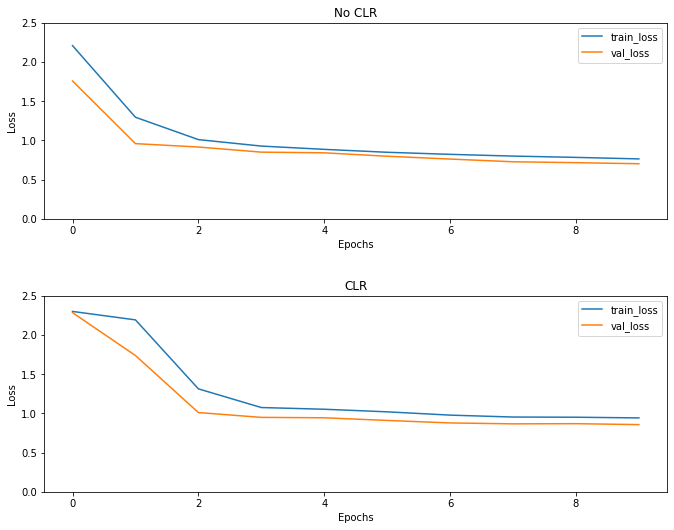

In [13]:
(fig, ax) = plt.subplots(2, 1, figsize=(10, 8))

ax[0].plot(no_clr_history.history["loss"], label="train_loss")
ax[0].plot(no_clr_history.history["val_loss"], label="val_loss")
ax[0].set_title("No CLR")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].set_ylim([0, 2.5])
ax[0].legend()

ax[1].plot(clr_history.history["loss"], label="train_loss")
ax[1].plot(clr_history.history["val_loss"], label="val_loss")
ax[1].set_title("CLR")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
ax[1].set_ylim([0, 2.5])
ax[1].legend()

fig.tight_layout(pad=3.0)
fig.show()

Even though for this toy example, you did not see the effects of CLR much but be noted that it is one of the main ingredients behind [Super Convergence](https://arxiv.org/abs/1708.07120) and can have a [really good impact](https://www.fast.ai/2018/08/10/fastai-diu-imagenet/) when training in large-scale settings. 